# POS Tagger Trained on the UD Treebank

Adapted from https://github.com/soutsios/pos_tagger_mlp/blob/master/pos_tagger_mlp.ipynb 

In [1]:
%pip install pyconll nltk numpy scipy matplotlib scikit-learn

import pyconll, nltk, datetime, warnings
import numpy as np
from scipy.sparse import vstack
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, learning_curve
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)
from numpy.random import seed

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Plot Functions

These functions are useful to visualize the training dynamics of the learning algorithm and the confusion matrix of the trained models.

In [2]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [3]:
def plot_confusion_matrix(f1,
                          cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          i=1):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    plt.figure(figsize=(10, 6))
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}; f1-score={:0.4f}'.format(accuracy, misclass, f1))

# Load Dataset

In [4]:
UD_ENGLISH_TRAIN = '../UD_English-EWT/en_ewt-ud-train.conllu'
UD_ENGLISH_DEV = '../UD_English-EWT/en_ewt-ud-dev.conllu'
UD_ENGLISH_TEST = '../UD_English-EWT/en_ewt-ud-test.conllu'

# Preprocessing

In [5]:
def read_conllu(path):
    data = pyconll.load_from_file(path)
    tagged_sentences=[]
    original_sentences=[]
    t=0
    for sentence in data:
        original_sentences.append(sentence.text)
        tagged_sentence=[]
        for token in sentence:
            if token.upos:
                t+=1
                tagged_sentence.append((token.form if token.form else '*None*', token.upos))
        tagged_sentences.append(tagged_sentence)
    return tagged_sentences, original_sentences

Load train, development and test set in the appropriate tagged format, tuple (word, pos-tag)

In [6]:
train_sentences, train_original = read_conllu(UD_ENGLISH_TRAIN)
val_sentences, val_original = read_conllu(UD_ENGLISH_DEV)
test_sentences, test_original = read_conllu(UD_ENGLISH_TEST)

Print statistics

In [7]:
print("Tagged sentences in train set: ", len(train_sentences))
print("Tagged words in train set:", len([item for sublist in train_sentences for item in sublist]))
print(40*'=')
print("Tagged sentences in dev set: ", len(val_sentences))
print("Tagged words in dev set:", len([item for sublist in val_sentences for item in sublist]))
print(40*'=')
print("Tagged sentences in test set: ", len(test_sentences))
print("Tagged words in test set:", len([item for sublist in test_sentences for item in sublist]))

Tagged sentences in train set:  12544
Tagged words in train set: 204616
Tagged sentences in dev set:  2001
Tagged words in dev set: 25153
Tagged sentences in test set:  2077
Tagged words in test set: 25096


In [8]:
print(train_sentences[0])

[('Al', 'PROPN'), ('-', 'PUNCT'), ('Zaman', 'PROPN'), (':', 'PUNCT'), ('American', 'ADJ'), ('forces', 'NOUN'), ('killed', 'VERB'), ('Shaikh', 'PROPN'), ('Abdullah', 'PROPN'), ('al', 'PROPN'), ('-', 'PUNCT'), ('Ani', 'PROPN'), (',', 'PUNCT'), ('the', 'DET'), ('preacher', 'NOUN'), ('at', 'ADP'), ('the', 'DET'), ('mosque', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('town', 'NOUN'), ('of', 'ADP'), ('Qaim', 'PROPN'), (',', 'PUNCT'), ('near', 'ADP'), ('the', 'DET'), ('Syrian', 'ADJ'), ('border', 'NOUN'), ('.', 'PUNCT')]


In [9]:
def tag_sequence(sentences):
    return [[t for w, t in sentence] for sentence in sentences]

def text_sequence(sentences):
    return [[w for w, t in sentence] for sentence in sentences]

def id2word(sentences):
    wordlist = [item for sublist in text_sequence(sentences) for item in sublist]
    id2word = {k:v for k,v in enumerate(wordlist)}
    return id2word

def untag(tagged_sentence):
    return [w for w, _ in tagged_sentence]

def untag_pos(tagged_sentence):
    return [t for _, t in tagged_sentence]

def build_vocab(sentences):
    vocab =set()
    for sentence in sentences:
        for word in untag(sentence):
            vocab.add(word)
    return sorted(list(vocab))

An important observation: how many terms are in validation set and not found in train set? (This estimates the Out-of-vocabulary rate.)

In [10]:
list_1 = build_vocab(train_sentences)
list_2 = build_vocab(val_sentences)
diff_list = [item for item in list_2 if item not in list_1]
print('Number of terms not found in train set:',len(diff_list))

Number of terms not found in train set: 1661


# Feature Engineering

We use the "classical" machine learning approach: we will train a token classifier model. The classifier gets as input a feature vector describing each token in the sentence. We decide a priori which features are informative to make the tagging decision. In this case, we use a combination of "word shape" features which approximate morphological knowledge. We naturally also include lexical information (the token form itself), and some form of "syntactic knowledge" by adding reference to the previous and next word in each token feature vector.

In [11]:
def features_basic(sentence, index):
    """ sentence: [w1, w2, ...], index: the index of the word """
    return {
        'nb_terms': len(sentence),        
        'word': sentence[index],
        'word_lower': sentence[index].lower(),
        'is_first': index == 0,
        'is_last': index == len(sentence) - 1,
        'is_capitalized': sentence[index][0].upper() == sentence[index][0],
        'is_all_caps': sentence[index].upper() == sentence[index],
        'is_all_lower': sentence[index].lower() == sentence[index],
        'prefix-1': sentence[index][0],
        'prefix-2': sentence[index][:2],
        'prefix-3': sentence[index][:3],
        'suffix-1': sentence[index][-1],
        'suffix-2': sentence[index][-2:],
        'suffix-3': sentence[index][-3:],
        'i-1_prefix-3': '' if index == 0 else sentence[index-1][:3],        
        'i-1_suffix-3': '' if index == 0 else sentence[index-1][-3:],        
        'i+1_prefix-3': '' if index == len(sentence) - 1 else sentence[index+1][:3],        
        'i+1_suffix-3': '' if index == len(sentence) - 1 else sentence[index+1][-3:],        
        'prev_word': '' if index == 0 else sentence[index - 1].lower(),
        'next_word': '' if index == len(sentence) - 1 else sentence[index + 1].lower(),
        'has_hyphen': '-' in sentence[index],
        'is_numeric': sentence[index].isdigit(),
        'capitals_inside': sentence[index][1:].lower() != sentence[index][1:],
    }

In the scikit-learn model, we model a dataset as a pair of two data structures:
* The list of feature dictionaries X (one feature dictionary for each token)
* The list of predicted label y (one tag for each token)

In [12]:
def transform_to_dataset(tagged_sentences):
    X, y = [], []
    for doc_index, tagged in enumerate(tagged_sentences):
        for index in range(len(tagged)):
            X.append([features_basic(untag(tagged), index)])
            y.append(tagged[index][1])
    return X, y

Given a sentence represented as a list of tokens, return the list of feature dictionaries using our feature encoding method:

In [13]:
def transform_test_sentence(sentence):
    X = []
    for index in range(len(sentence)):
            X.append([features_basic(sentence, index)])
    return X

## Test untag()

We use untag() to extract raw sentences from the annotated CoNLL dataset. This way we can reproduce a sentence without tags, submit it to the tagger and compare predictions to the gold tags that are provided in the dataset.

In [14]:
untag(test_sentences[1])

['What',
 'if',
 'Google',
 'expanded',
 'on',
 'its',
 'search',
 '-',
 'engine',
 '(',
 'and',
 'now',
 'e-mail',
 ')',
 'wares',
 'into',
 'a',
 'full',
 '-',
 'fledged',
 'operating',
 'system',
 '?']

# Dataset Transformation

Before we can apply a generic machine learning algorithm (such as Logistic Regression), we need to encode the dataset into a vectorized format.

We proceed in two steps: feature engineering and vectorization.

For each token, we create a dictionary of features that depend on the sentence from which the token is extracted. 
These features include the word itself, the word before and the word after, letter suffixes and prefixes, etc.

In the scikit-learn approach, before we can use a generic machine learning algorithm, we must then "vectorize" the feature dictionaries into vector encodings.
For example, lexical features are encoded into one-hot vectors whose dimension is the size of the vocabulary.
Note the difference between the method `fit_transform` of the vectorizer, which "learns" how to vectorize features, and `transform` which applies a learned vectorizer to feature dictionaries.  We use `fit_transform` on the training data, and `transform` on the other sections (validation and test).

These vector representations are what is passed to the machine learning algorithm.

In [15]:
def vectorize(train, val, test):

    print('Feature encoding method')
    print('Vectorizing Dataset...')
    print('Vectorizing train...')
    X_train, y_train = transform_to_dataset(train)
    v = DictVectorizer(sparse=True) 
    X_train = v.fit_transform([x[0] for x in X_train])
    
    print('Vectorizing validation...')
    X_val, y_val = transform_to_dataset(val)
    X_val = v.transform([x[0] for x in X_val])        
    
    print('Vectorizing test...')
    X_test, y_test = transform_to_dataset(test)
    X_test = v.transform([x[0] for x in X_test])
    
    print('Dataset vectorized.')
    print('Train shape:', X_train.shape)
    print('Validation shape:', X_val.shape)
    print('Test shape:', X_test.shape)
    
    # Compress sparse matrices
    X_train = X_train 
    X_val = X_val 
    X_test = X_test
    return X_train, y_train, X_val, y_val, X_test, y_test, v
    

# Baseline Tagger

Before we train a "real" machine learning algorithm using scikit-learn, we will repeat the very simple statistical method we discussed in class.
We train and evaluate the Baseline Unigram tagger to compare performance with the tagger we will train next.

In [16]:
default_tagger = nltk.DefaultTagger('NOUN')
unigram_tagger = nltk.UnigramTagger(train_sentences+val_sentences, backoff=default_tagger)

In [17]:
y_train = [item for sublist in tag_sequence(train_sentences+val_sentences) for item in sublist]
y_test = [item for sublist in tag_sequence(test_sentences) for item in sublist]
classes = sorted(list(set(y_train)))

In [18]:
def tag_list(tagged_sents):
    return [tag for sent in tagged_sents for (word, tag) in sent]
def apply_tagger(tagger, corpus):
    return [tagger.tag(nltk.tag.untag(sent)) for sent in corpus]

In [19]:
y_pred = tag_list(apply_tagger(unigram_tagger, test_sentences))
print("Accuracy: {0:.4f}".format(unigram_tagger.accuracy(test_sentences)))
print('f1-macro score: {0:.4f}'.format(f1_score(y_test, y_pred, zero_division=1, average='macro')))

Accuracy: 0.8671
f1-macro score: 0.7965


In [20]:
print(classification_report(y_test, y_pred, zero_division=1, digits=4))

              precision    recall  f1-score   support

         ADJ     0.9158    0.8367    0.8745      1794
         ADP     0.8697    0.8813    0.8755      2030
         ADV     0.9341    0.8030    0.8636      1183
         AUX     0.9233    0.8970    0.9099      1543
       CCONJ     0.9892    0.9973    0.9932       736
         DET     0.9612    0.9678    0.9645      1896
        INTJ     0.9655    0.6942    0.8077       121
        NOUN     0.6879    0.9331    0.7920      4123
         NUM     0.9146    0.6125    0.7337       542
        PART     0.6959    0.9769    0.8128       649
        PRON     0.9665    0.9321    0.9490      2166
       PROPN     0.9240    0.5443    0.6851      2076
       PUNCT     0.9941    0.9861    0.9901      3096
       SCONJ     0.6257    0.5964    0.6107       384
         SYM     0.8125    0.8349    0.8235       109
        VERB     0.8880    0.8243    0.8549      2606
           X     1.0000    0.0000    0.0000        42

    accuracy              

See what errors the Baseline tagger makes:

In [21]:
def check_tagger(tagged_sentence):
    note = ''
    for tup in list(zip(unigram_tagger.tag(untag(tagged_sentence)),untag_pos(tagged_sentence))):
        if tup[0][1]!=tup[1]: note='<<--- Error!'
        print(tup[0], tup[1], note)
        note=''

In [22]:
check_tagger(test_sentences[1])

('What', 'PRON') PRON 
('if', 'SCONJ') SCONJ 
('Google', 'PROPN') PROPN 
('expanded', 'VERB') VERB 
('on', 'ADP') ADP 
('its', 'PRON') PRON 
('search', 'NOUN') NOUN 
('-', 'PUNCT') PUNCT 
('engine', 'NOUN') NOUN 
('(', 'PUNCT') PUNCT 
('and', 'CCONJ') CCONJ 
('now', 'ADV') ADV 
('e-mail', 'NOUN') NOUN 
(')', 'PUNCT') PUNCT 
('wares', 'NOUN') NOUN 
('into', 'ADP') ADP 
('a', 'DET') DET 
('full', 'ADJ') ADV <<--- Error!
('-', 'PUNCT') PUNCT 
('fledged', 'NOUN') ADJ <<--- Error!
('operating', 'NOUN') NOUN 
('system', 'NOUN') NOUN 
('?', 'PUNCT') PUNCT 


It makes mistakes. Unsurprising given its simplistic approach and the small size of the training data.

In [23]:
cnf_matrix = confusion_matrix(y_test, y_pred)
name='Baseline'

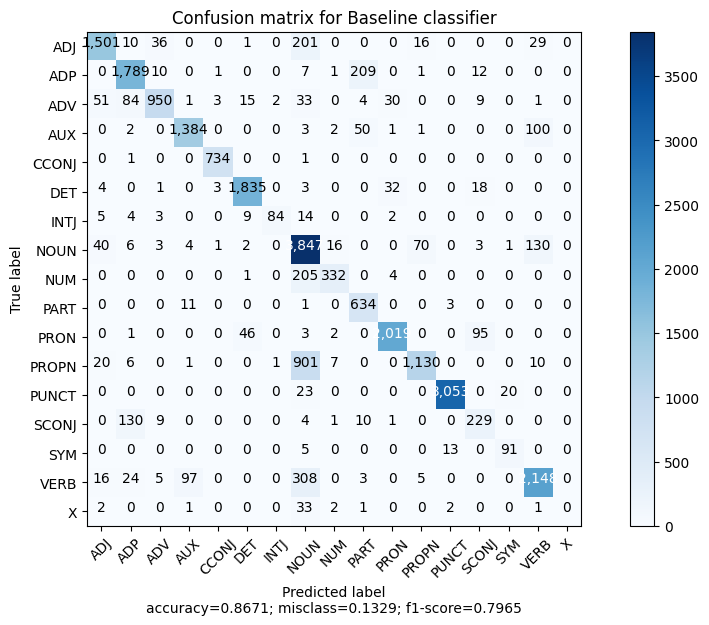

In [24]:
plot_confusion_matrix(f1_score(y_test, y_pred, average='macro'), cnf_matrix, target_names=classes, title='Confusion matrix for '+name+' classifier', normalize=False)

# Train a Logistic Regression Model

Let us move to a more serious machine learning model. We will train a Logistic Regression model using our feature extraction function based on our "expertise" in the domain.

We first transform the whole dataset from the CoNLL format into the scikit-learn vectorized encoding using our feature extraction method.

In [25]:
X_train, y_train, X_val, y_val, X_test, y_test, vec = vectorize(train_sentences, val_sentences, test_sentences)

Feature encoding method
Vectorizing Dataset...
Vectorizing train...
Vectorizing validation...
Vectorizing test...
Dataset vectorized.
Train shape: (204616, 98724)
Validation shape: (25153, 98724)
Test shape: (25096, 98724)


## Hyper-parameter Tuning

The Logistic Regression algorithm uses a hyper-parameter called C.  We tune the value of this parameter by testing different values on a subset of the training data and observing the impact of the C parameter on selected metrics (accuracy and F1).

Because we will use cross-validation, we can use the full train set (train + validation)

In [26]:
X_train = vstack((X_train, X_val))
y_train = np.append(y_train, y_val, axis=0)

In [27]:
X_train.shape

(229769, 98724)

In [28]:
y_train.shape

(229769,)

In [29]:
def hyper_tuning(train, test, y_train, y_test, scores, estimator, parameters, cv):
    print("# Estimator:",estimator)
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)        
        clf = GridSearchCV(estimator, parameters, cv=cv, scoring='%s' % score)
        clf.fit(train, y_train)
        print("Best parameters set found on development set:")
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print()
        print("Detailed classification report:")
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        y_pred = clf.predict(test)
        print(classification_report(y_test, y_pred, digits=4))
        print('Accuracy: {0:0.4f}   f1-score: {1:0.4f} \n'.format(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='macro')))
    return clf

In [30]:
logregr = LogisticRegression(solver='liblinear', random_state=13)
# Cross validation strategy
skf = StratifiedKFold(n_splits=4)
# Scores could also be ['precision', 'recall', ....]
scores = ['accuracy', 'f1_macro']

params = [{'C': [0.1, 1, 2, 3, 4, 5, 10, 20, 50]}]
#logregr = hyper_tuning(X_train, X_test, y_train, y_test, scores, logregr, params, skf)
#You may want to comment previous line and comment-out next lines to see how hyper-tuning works and dont wait too much time...
skf = StratifiedKFold(n_splits=4)
logregr = hyper_tuning(X_train[:500], X_test[:50], y_train[:500], y_test[:50], scores, logregr, params, skf)

# Estimator: LogisticRegression(random_state=13, solver='liblinear')
# Tuning hyper-parameters for accuracy
Best parameters set found on development set:
{'C': 20}

Grid scores on development set:
0.748 (+/-0.027) for {'C': 0.1}
0.828 (+/-0.046) for {'C': 1}
0.834 (+/-0.041) for {'C': 2}
0.836 (+/-0.035) for {'C': 3}
0.836 (+/-0.035) for {'C': 4}
0.838 (+/-0.029) for {'C': 5}
0.842 (+/-0.033) for {'C': 10}
0.846 (+/-0.035) for {'C': 20}
0.844 (+/-0.042) for {'C': 50}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

         ADJ     0.0000    0.0000    0.0000         2
         ADP     1.0000    0.6667    0.8000         6
         ADV     0.0000    0.0000    0.0000         3
         AUX     1.0000    1.0000    1.0000         1
       CCONJ     1.0000    0.5000    0.6667         2
         DET     0.6667    1.0000    0.8000         2
        NOUN  

## Training

We can now training using the best hyper-parameter selected above.  This takes a few minutes.

In [31]:
t_ini = datetime.datetime.now()
print('Training...')
clf = LogisticRegression(C=20, solver='liblinear', random_state=13)
clf.fit(X_train, y_train)
t_fin = datetime.datetime.now()
print('Training completed in {} seconds'.format((t_fin - t_ini).total_seconds()))

Training...
Training completed in 330.923574 seconds


# Evaluation

In [32]:
y_pred = clf.predict(X_test)

In [33]:
print("Accuracy: {0:.4f}".format(clf.score(X_test, y_test)))
print('f1-macro score: {0:.4f}'.format(f1_score(y_test, y_pred, average='macro')))

Accuracy: 0.9448
f1-macro score: 0.9020


## Classification Report

In [34]:
print(classification_report(y_test, clf.predict(X_test), digits=4))

              precision    recall  f1-score   support

         ADJ     0.9198    0.9019    0.9108      1794
         ADP     0.9329    0.9586    0.9456      2030
         ADV     0.9204    0.8893    0.9046      1183
         AUX     0.9787    0.9812    0.9799      1543
       CCONJ     0.9946    0.9932    0.9939       736
         DET     0.9905    0.9910    0.9908      1896
        INTJ     0.9712    0.8347    0.8978       121
        NOUN     0.9033    0.9200    0.9116      4123
         NUM     0.9743    0.9779    0.9761       542
        PART     0.9799    0.9769    0.9784       649
        PRON     0.9871    0.9866    0.9868      2166
       PROPN     0.8810    0.8593    0.8700      2076
       PUNCT     0.9913    0.9971    0.9942      3096
       SCONJ     0.8540    0.8073    0.8300       384
         SYM     0.8990    0.8165    0.8558       109
        VERB     0.9433    0.9570    0.9501      2606
           X     0.4800    0.2857    0.3582        42

    accuracy              

## Frequent Types of Mistakes

In [35]:
import collections
k=0
i2w = id2word(test_sentences)
error_counter = collections.Counter()
for i in range(X_test.shape[0]):
    correct_tag_id = y_test
    if y_pred[i]!=y_test[i]:
        k += 1
        word = i2w[i]
        error_counter[word] += 1
print('Accuracy: {0:.4f}'.format((len(i2w)-k)/len(i2w)))
print('Total errors/Total words: {}/{}\n'.format(k,len(i2w)))
print('Most common errors:',error_counter.most_common(20))

Accuracy: 0.9448
Total errors/Total words: 1385/25096

Most common errors: [('that', 25), ('as', 23), ('to', 23), ('like', 22), ('out', 18), ('for', 18), ('up', 18), ('/', 17), ('in', 17), ('on', 12), ('01-Feb-02', 11), ('much', 10), ('one', 9), ('-', 9), ('so', 8), ('all', 7), ('have', 7), ('be', 7), ('of', 6), ('has', 6)]


## Learning Curves

The following diagram illustrates the "training dynamics" of the LR model: how fast does it improve as it keeps training. Originally, the difference between the test dataset and the cross-validation (on part of the test data) is large; as training proceeds, the gap reduces. This diagram is important to verify we do not have a case of over-fitting - where the model does "very well" on training data and does not improve on test data.  

This computation takes a long time (as we keep training and evaluating multiple times to obtain the snapshots). It is not necessary to run the rest of the notebook so that you can safely skip it.

In [36]:
#plot_learning_curve(clf, 'Logistic Regression', X_train, y_train, ylim=(0.7, 1.01), cv=5) #skipped, not mandatory for the rest of the code

## Confusion Matrix

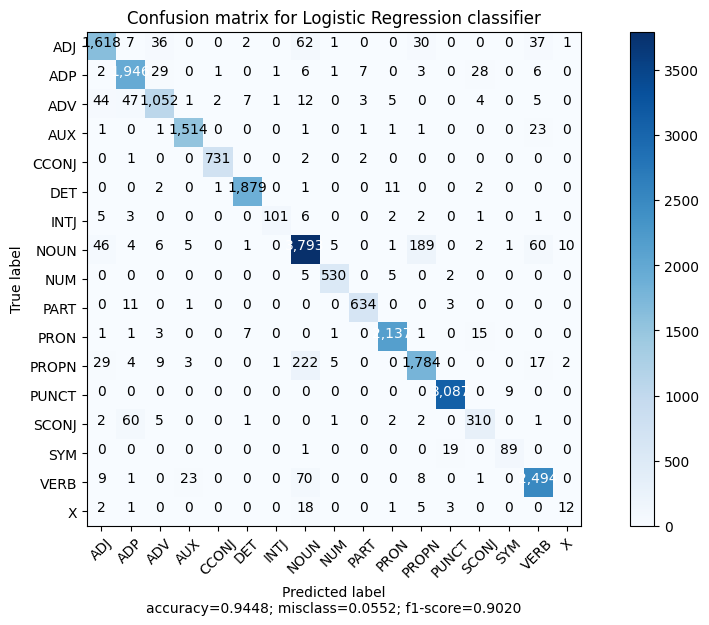

In [37]:
y_pred = clf.predict(X_test)
f1 = f1_score(y_test, y_pred, average='macro')
cnf_matrix = confusion_matrix(y_test, y_pred)
name='Logistic Regression'
plot_confusion_matrix(f1, cnf_matrix, target_names=classes, title='Confusion matrix for '+name+' classifier', normalize=False)

## Tag an Unknown Sentence

Lets try our trained tagger on new sentences.  To tag a sentence given as a string, we must apply the following steps:
* Tokenize the string into a list of tokens
* Turn each token into a features dictionary (using the features used by our model)
* Turn the list of feature dictionaries into vectors (using scikit-learn vectorization method)
* Pass the resulting matrix (one row vector for each token) to the classifier.

In [38]:
# Need to download the nltk model for sentence tokenizer
nltk.download('punkt_tab')

[nltk_data] Error loading punkt_tab: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     Missing Authority Key Identifier (_ssl.c:1028)>


False

In [39]:
tokens = nltk.word_tokenize('Word embeddings provide a dense representation of words and their relative meanings.')
print(tokens)

['Word', 'embeddings', 'provide', 'a', 'dense', 'representation', 'of', 'words', 'and', 'their', 'relative', 'meanings', '.']


In [40]:
X_features = transform_test_sentence(tokens)

In [41]:
X_features

[[{'nb_terms': 13,
   'word': 'Word',
   'word_lower': 'word',
   'is_first': True,
   'is_last': False,
   'is_capitalized': True,
   'is_all_caps': False,
   'is_all_lower': False,
   'prefix-1': 'W',
   'prefix-2': 'Wo',
   'prefix-3': 'Wor',
   'suffix-1': 'd',
   'suffix-2': 'rd',
   'suffix-3': 'ord',
   'i-1_prefix-3': '',
   'i-1_suffix-3': '',
   'i+1_prefix-3': 'emb',
   'i+1_suffix-3': 'ngs',
   'prev_word': '',
   'next_word': 'embeddings',
   'has_hyphen': False,
   'is_numeric': False,
   'capitals_inside': False}],
 [{'nb_terms': 13,
   'word': 'embeddings',
   'word_lower': 'embeddings',
   'is_first': False,
   'is_last': False,
   'is_capitalized': False,
   'is_all_caps': False,
   'is_all_lower': True,
   'prefix-1': 'e',
   'prefix-2': 'em',
   'prefix-3': 'emb',
   'suffix-1': 's',
   'suffix-2': 'gs',
   'suffix-3': 'ngs',
   'i-1_prefix-3': 'Wor',
   'i-1_suffix-3': 'ord',
   'i+1_prefix-3': 'pro',
   'i+1_suffix-3': 'ide',
   'prev_word': 'word',
   'next_word'

In [42]:
X_vectorized = vec.transform([x[0] for x in X_features])

In [43]:
# The vectorized sentence is a sparse matrix with one row for each token and columns for the vectorized features
# For example, if the vocabulary has 1000 unique words, the vectorized sentence will have 1000 columns for each word feature.
# This is a very sparse matrix, where most of the values are zero.
X_vectorized.shape

(13, 98724)

In [44]:
pred = clf.predict(X_vectorized)

In [45]:
# np.str_ is a subclass of str that is used to represent string arrays in NumPy.
print('Here is what our LR tagger predicts for the test sentence:\n',list(zip(tokens, pred)))

Here is what our LR tagger predicts for the test sentence:
 [('Word', np.str_('PROPN')), ('embeddings', np.str_('NOUN')), ('provide', np.str_('VERB')), ('a', np.str_('DET')), ('dense', np.str_('ADJ')), ('representation', np.str_('NOUN')), ('of', np.str_('ADP')), ('words', np.str_('NOUN')), ('and', np.str_('CCONJ')), ('their', np.str_('PRON')), ('relative', np.str_('ADJ')), ('meanings', np.str_('NOUN')), ('.', np.str_('PUNCT'))]


Let's turn this process into a prediction function from a sentence encoded as a single string to a list of pairs (token, predicted_tag):

In [46]:
def predict_sentence(sentence):
   tokens = nltk.word_tokenize(sentence)
   X_features = transform_test_sentence(tokens)
   X_vectorized = vec.transform([x[0] for x in X_features])
   pred = clf.predict(X_vectorized)
   return list(zip(tokens, pred))

In [47]:
predict_sentence("Let me join the chorus of annoyance over Google's new toolbar , which, as noted in the linked article, commits just about every sin an online marketer could commit, and makes up a few new ones besides.")

[('Let', np.str_('VERB')),
 ('me', np.str_('PRON')),
 ('join', np.str_('VERB')),
 ('the', np.str_('DET')),
 ('chorus', np.str_('NOUN')),
 ('of', np.str_('ADP')),
 ('annoyance', np.str_('NOUN')),
 ('over', np.str_('ADP')),
 ('Google', np.str_('PROPN')),
 ("'s", np.str_('PART')),
 ('new', np.str_('ADJ')),
 ('toolbar', np.str_('NOUN')),
 (',', np.str_('PUNCT')),
 ('which', np.str_('PRON')),
 (',', np.str_('PUNCT')),
 ('as', np.str_('SCONJ')),
 ('noted', np.str_('VERB')),
 ('in', np.str_('ADP')),
 ('the', np.str_('DET')),
 ('linked', np.str_('VERB')),
 ('article', np.str_('NOUN')),
 (',', np.str_('PUNCT')),
 ('commits', np.str_('NOUN')),
 ('just', np.str_('ADV')),
 ('about', np.str_('ADV')),
 ('every', np.str_('DET')),
 ('sin', np.str_('VERB')),
 ('an', np.str_('DET')),
 ('online', np.str_('ADJ')),
 ('marketer', np.str_('NOUN')),
 ('could', np.str_('AUX')),
 ('commit', np.str_('VERB')),
 (',', np.str_('PUNCT')),
 ('and', np.str_('CCONJ')),
 ('makes', np.str_('VERB')),
 ('up', np.str_('ADP'

# Collect Hard Sentences

Hard sentences are sentences that contain multiple wrongly predicted tags given our classifier.

Write code to collect hard sentences given a classifier clf.

In [48]:
def errors_in_sentence_prediction(clf, tagged_sentence):
    """Given a tagged sentence from the dataset, return the number of errors and the predicted tags."""
    errors = 0
    
    # Extract words from the tagged sentence
    words = untag(tagged_sentence)
    
    # Create feature dictionaries for each word
    X_features = transform_test_sentence(words)
    
    # Vectorize features
    X_vectorized = vec.transform([x[0] for x in X_features])
    
    # Make predictions
    pred = clf.predict(X_vectorized)
    
    # Count errors by comparing predictions with actual tags
    true_tags = untag_pos(tagged_sentence)
    for i in range(len(true_tags)):
        if pred[i] != true_tags[i]:
            errors += 1
    
    return errors, pred

In [49]:
hard_sentences = []
for s in test_sentences:
    errors, pred = errors_in_sentence_prediction(clf, s)
    if errors > 0:
        hard_sentences.append((s, errors, pred))
print(f'Number of sentences with errors: {len(hard_sentences)} out of {len(test_sentences)}')

Number of sentences with errors: 803 out of 2077


Draw a histogram showing how the sentences in the test dataset are distributed in terms of prediction errors per sentence.

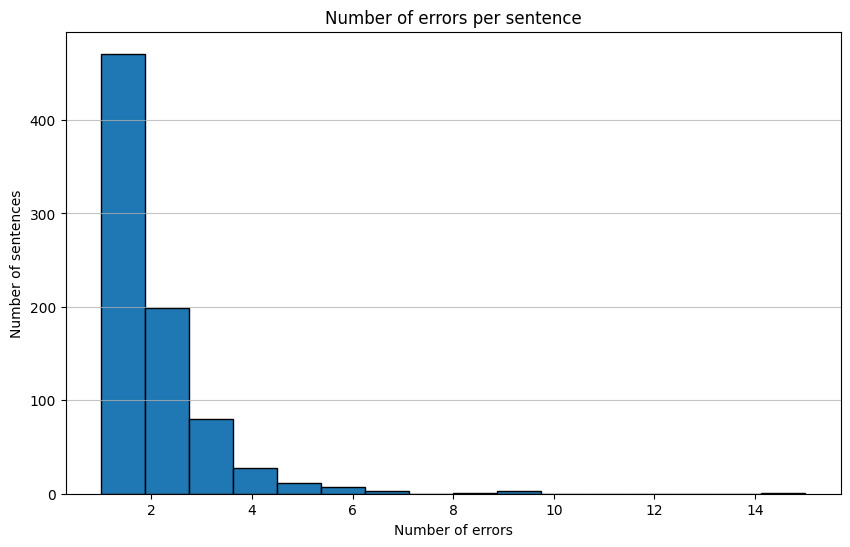

In [50]:
# Draw a histogram of the number of errors per sentence
plt.figure(figsize=(10, 6))
plt.hist([x[1] for x in hard_sentences], bins=16, edgecolor='black')
plt.title('Number of errors per sentence')
plt.xlabel('Number of errors')
plt.ylabel('Number of sentences')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [51]:
# Show prediction errors for sentences with more than 5 errors.
for s in hard_sentences:
    if s[1] > 5:
        print(" ".join(untag(s[0])))
        print('Number of errors:', s[1])
        for i in range(len(s[0])):
            if s[0][i][1] != s[2][i]:
                print(f'{s[0][i][0]:<20}  C: {s[0][i][1]:<12}  P: {s[2][i]:<12} **** Error')
            else:
                print(f'{s[0][i][0]:<23}  {s[0][i][1]:<12}')
        print(40*'=')


Stay with me now : John Paul STEVENS delivered the opinion of the Court with respect to Parts I through IV , VI through VI - D - iii , VI - D - v , and VII , in which KENNEDY , SOUTER , GINSBURG , and BREYER joined , and an opinion with respect to Parts V and VI - D - iv , in which SOUTER , GINSBURG , and BREYER joined .
Number of errors: 8
Stay                     VERB        
with                     ADP         
me                       PRON        
now                      ADV         
:                        PUNCT       
John                     PROPN       
Paul                     PROPN       
STEVENS               C: PROPN         P: NOUN         **** Error
delivered                VERB        
the                      DET         
opinion                  NOUN        
of                       ADP         
the                      DET         
Court                    NOUN        
with                     ADP         
respect                  NOUN        
to                   

## 

## Error Analysis

1. Identify tokens that are misclassified more than 10 times in the test set. Print the sentences where the errors are predicted (about 100 sentences).
2. Provide a possible reason why these errors are made by the tagger based on your understanding of the knowledge needed to correctly tag these tokens.
3. Based on this error analysis, invent five sentences that are badly tagged. Explain what is your method to create these hard examples.


#### 1. Identify tokens that are misclassified more than 10 times in the test set. Print the sentences where the errors are predicted (about 100 sentences).

In [52]:
def identify_misclassified_tokens(hard_sentences):
    """
    Identify tokens that are misclassified more than 10 times in the test set.
    Print sentences where these frequent errors appear.
    
    Args:
        hard_sentences: List of tuples (tagged_sentence, num_errors, predicted_tags)
    """
    # Count occurrences of each token being misclassified
    token_error_counter = collections.Counter()
    
    # Create a dictionary to map tokens to tag patterns (correct -> predicted)
    token_tag_patterns = {}
    
    # Create a dictionary to store sentences containing each token error
    token_to_sentences = {}
    
    # For each hard sentence
    for s_idx, (sentence, _, pred_tags) in enumerate(hard_sentences):
        # For each token in the sentence
        for i, (word, true_tag) in enumerate(sentence):
            # If the token is misclassified
            if true_tag != pred_tags[i]:
                # Count the error
                token_error_counter[word] += 1
                
                # Track the tag pattern
                if word not in token_tag_patterns:
                    token_tag_patterns[word] = set()
                token_tag_patterns[word].add((true_tag, pred_tags[i]))
                
                # Associate the sentence with this token
                if word not in token_to_sentences:
                    token_to_sentences[word] = []
                token_to_sentences[word].append(s_idx)
    
    # Get tokens misclassified more than 10 times
    frequent_errors = [token for token, count in token_error_counter.items() if count > 10]
    frequent_errors.sort(key=lambda x: token_error_counter[x], reverse=True)
    
    print(f"Number of tokens misclassified more than 10 times: {len(frequent_errors)}")
    print("\nFrequently misclassified tokens:")
    
    for token in frequent_errors:
        print(f"\n'{token}' was misclassified {token_error_counter[token]} times")
        print("Tag patterns (Correct -> Predicted):")
        for true_tag, pred_tag in token_tag_patterns[token]:
            print(f"  {true_tag} -> {pred_tag}")
    
    # Print sample sentences containing these frequently misclassified tokens
    print("\nSample sentences with frequently misclassified tokens:")
    sentences_printed = 0
    
    # Print sentences containing frequent errors (up to 100)
    for token in frequent_errors:
        # Print up to 3 sentences per token to avoid bias toward any single token
        for s_idx in token_to_sentences[token][:3]:
            if sentences_printed >= 100:
                break
                
            sentence, _, pred_tags = hard_sentences[s_idx]
            print(f"\nSentence with '{token}' error:")
            print(" ".join(untag(sentence)))
            
            # Print each token with its tags, highlighting errors
            for i, (word, true_tag) in enumerate(sentence):
                if true_tag != pred_tags[i]:
                    marker = "**** Frequent error" if word in frequent_errors else "**** Error"
                    print(f"{word:<20}  C: {true_tag:<12}  P: {pred_tags[i]:<12} {marker}")
            
            print(40*'-')
            sentences_printed += 1
        
        if sentences_printed >= 100:
            break
    
    print(f"Total sentences printed: {sentences_printed}")
    
    return frequent_errors, token_error_counter

In [53]:
# First run the identify_misclassified_tokens function
frequent_errors, error_counter = identify_misclassified_tokens(hard_sentences)

# Print ALL tokens that were misclassified more than 10 times
print("\nComplete list of tokens misclassified more than 10 times:")
for token, count in sorted(error_counter.items(), key=lambda x: x[1], reverse=True):
    if count > 10:
        print(f"'{token}': {count} times")

Number of tokens misclassified more than 10 times: 11

Frequently misclassified tokens:

'that' was misclassified 25 times
Tag patterns (Correct -> Predicted):
  ADV -> PRON
  SCONJ -> PRON
  PRON -> DET
  SCONJ -> DET
  ADV -> SCONJ
  PRON -> SCONJ
  DET -> PRON
  DET -> SCONJ

'as' was misclassified 23 times
Tag patterns (Correct -> Predicted):
  SCONJ -> ADV
  ADP -> ADV
  ADV -> ADP
  SCONJ -> ADP
  ADP -> SCONJ

'to' was misclassified 23 times
Tag patterns (Correct -> Predicted):
  ADV -> ADP
  ADV -> PART
  ADP -> PART
  X -> ADP
  PART -> ADP

'like' was misclassified 22 times
Tag patterns (Correct -> Predicted):
  SCONJ -> ADJ
  ADP -> VERB
  ADJ -> ADP
  ADP -> ADJ
  SCONJ -> ADP
  ADP -> INTJ
  ADP -> SCONJ
  VERB -> ADP
  VERB -> SCONJ
  INTJ -> ADP

'out' was misclassified 18 times
Tag patterns (Correct -> Predicted):
  ADV -> VERB
  ADP -> ADV
  PROPN -> VERB
  ADV -> ADP
  ADP -> NOUN
  PRON -> ADP
  PROPN -> ADP
  NOUN -> ADV

'for' was misclassified 18 times
Tag pattern

### 2. Provide a possible reason why these errors are made by the tagger based on your understanding of the knowledge needed to correctly tag these tokens.

The most frequently misclassified tokens ('that', 'as', 'to', 'like', 'out', 'for') are primarily function words with high grammatical ambiguity. These words can serve multiple syntactic roles depending on context - for example, 'that' functions as a determiner, pronoun, or subordinating conjunction in different situations. 

The tagger struggles because these distinctions require understanding of complete syntactic structures rather than just local word patterns. Function words are especially challenging because their correct classification depends on their syntactic role in the sentence, not their lexical meaning.

For example:


#### Out
The word "out" can be used as PRON, DET, SCONJ and more.

For example, in the sentence "Wiki Media Foundation , the group behind the Wikipedia online encyclopedia project , said Friday that search giant Google has volunteered to host some of its content on company servers ."

In this example, the word "that" serves to connect the reporting verb "said" to the clause that follows, forming a subordinate or content clause. As such, "that" is correctly labeled as a subordinating conjunction (SCONJ). However, "that" can also act as a determiner, as in the sentence "That book is mine," where it modifies the noun "book" and is tagged as DET. 



#### On
The word "on" can serve multiple grammatical roles. In most cases, it's a preposition (ADP), as in:
"The book is on the table." -> "on" = ADP (shows spatial relation)

However, in some contexts, "on" functions differently. For example, in the sentence:
"John Donovan from Argghhh! has put out a excellent slide show on what was actually found and fought for in Fallujah."

Here, "on" introduces a complement clause, meaning it connects to what the slide show is about. In the Universal Dependencies (UD) framework, it can be interpreted as part of a subordinating phrase, sometimes leading to confusion with SCONJ (subordinating conjunction) or even ADV in ambiguous cases.

This highlights a syntactic ambiguity, where distinguishing between prepositional phrase structure and embedded clauses requires deeper syntactic parsing.

#### Like
The word "like" is another highly ambiguous token. It can serve as:
A preposition (ADP): "She looks like her mother."

A verb (VERB): "I like chocolate."
A conjunction (SCONJ): "It looks like he’s leaving."
Even an adjective (ADJ) or interjection (INTJ) in casual speech.

In the sentence:
"It looks like The Lunar Transportation Systems, Inc. is visualizing a 'space highway' going from the moon to Earth (and back again)."

“Like” functions to introduce a clause, making it a subordinating conjunction (SCONJ). However, a model might wrongly tag it as a preposition if it interprets “like The Lunar Transportation Systems” as a comparative phrase, e.g., “It looks like a spaceship.”



#### 3. Based on this error analysis, invent five sentences that are badly tagged. Explain what is your method to create these hard examples.
Based on our analysis, a hard sentence if one which have ambiguity n different layers that result in the model choosing the common usage of the word instead of the correct one based on the sentence.

1. That that that student analyzed confused the professor who thought that that analysis was incomplete.

2. Like many before him, he felt like giving up, but then it seemed like the problem had a solution.

3. For years she worked for recognition, for her career depended on it, but for all her efforts, little changed.

4. The team set up the equipment to set up the experiment, only to find out that time was up.

5. As she walked in as the new director, everyone looked as surprised as they had been told to appear.


My method creates challenging sentences by exploiting grammatical ambiguity in frequently misclassified function words. I deliberately used the same ambiguous words ("that," "like," "for," "up," "as") multiple times within single sentences, assigning each instance a different grammatical role. This forces the tagger to disambiguate between competing interpretations without relying on lexical information alone. The sentences contain syntactic structures where local context is insufficient, requiring understanding of complete sentence structure to determine the correct part-of-speech tag.


## Create an LLM Baseline for POS Tagging

### 1. Compute the same statistics reported for the Logistic Regression Tagger in the notebook for the LLM Tagger (token-level metric).
Create a simple zero-shot prompt to instruct the LLM to tag a list of sentences with the UD tagset.
The API-Based tagger is at ud_pos_tagger_gemini.py

In [54]:
%pip install google-genai
from ud_pos_tagger_gemini import tag_sentences_ud


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Using secondary key
Error configuring Gemini API: module 'google.genai' has no attribute 'configure'
Please ensure you have a valid API key set.


In [55]:
# Filter the hard sntences to save only the ones with 1-3 errors
filtered_hard_sentences = [sentence for sentence in hard_sentences if 1 <= sentence[1] <= 3]
print(len(filtered_hard_sentences))

750


In [56]:
def compute_token_metrics(gold_tags, predicted_tags):
    """
    Compute token-level metrics for the tagger.
    
    Args:
        gold_tags: List of gold standard tags
        predicted_tags: List of predicted tags
    
    Returns:
        Dictionary with metrics
    """
    metrics = {
        'accuracy': accuracy_score(gold_tags, predicted_tags),
        'f1_macro': f1_score(gold_tags, predicted_tags, average='macro'),
        'classification_report': classification_report(gold_tags, predicted_tags, digits=4)
    }
    return metrics

In [57]:
def compare_tagger_errors(hard_sentences, llm_results):
    """
    Compare errors between LR tagger and LLM tagger.
    
    Args:
        hard_sentences: List of tuples (tagged_sentence, num_errors, predicted_tags_by_LR)
        llm_results: Results from LLM tagger evaluation
    
    Returns:
        Dictionary with error comparison statistics
    """
    comparison = {
        'fixed_by_llm': 0,
        'new_errors_by_llm': 0,
        'common_errors': 0,
        'different_errors': 0,
        'error_tokens': {
            'fixed': [],
            'new': [],
            'common': []
        }
    }
    
    gold_tags = llm_results['gold_tags']
    lr_predictions = llm_results['lr_predictions']
    llm_predictions = llm_results['llm_predictions']
    
    token_idx = 0
    for sentence_idx, (tagged_sentence, _, _) in enumerate(hard_sentences):
        for word_idx, (word, gold) in enumerate(tagged_sentence):
            if token_idx >= len(gold_tags):
                break
                
            lr = lr_predictions[token_idx]
            llm = llm_predictions[token_idx]
            
            # Case 1: LR wrong, LLM correct
            if gold != lr and gold == llm:
                comparison['fixed_by_llm'] += 1
                comparison['error_tokens']['fixed'].append((word, gold, lr, llm))
            
            # Case 2: LR correct, LLM wrong
            elif gold == lr and gold != llm:
                comparison['new_errors_by_llm'] += 1
                comparison['error_tokens']['new'].append((word, gold, lr, llm))
            
            # Case 3: Both wrong (possibly in same or different ways)
            elif gold != lr and gold != llm:
                comparison['common_errors'] += 1
                comparison['error_tokens']['common'].append((word, gold, lr, llm))
            
            token_idx += 1
    
    return comparison

In [58]:
def analyze_sentence_errors(hard_sentences, llm_results):
    """
    Analyze the distribution of errors per sentence.
    
    Args:
        hard_sentences: List of hard sentences with LR errors
        llm_results: Results from LLM tagger evaluation
    
    Returns:
        Error counts per sentence for both taggers
    """
    import numpy as np
    
    lr_error_counts = [num_errors for _, num_errors, _ in hard_sentences[:len(llm_results['sentence_errors'])]]
    llm_error_counts = llm_results['sentence_errors']
    
    # Create categories for errors: 1 error, 2 errors, 3+ errors
    # For LR tagger
    lr_error_categories = [
        sum(1 for e in lr_error_counts if e == 1),
        sum(1 for e in lr_error_counts if e == 2),
        sum(1 for e in lr_error_counts if e >= 3)
    ]

    # For LLM tagger
    llm_error_categories = [
        sum(1 for e in llm_error_counts if e == 1),
        sum(1 for e in llm_error_counts if e == 2),
        sum(1 for e in llm_error_counts if e >= 3)
    ]
    
    # Plot grouped bar chart for comparison
    plt.figure(figsize=(12, 6))
    
    categories = ['1 error', '2 errors', '3+ errors']
    x = np.arange(len(categories))
    width = 0.35
    
    plt.bar(x - width/2, lr_error_categories, width, label='LR Tagger', alpha=0.7, edgecolor='black')
    plt.bar(x + width/2, llm_error_categories, width, label='LLM Tagger', alpha=0.7, edgecolor='black')
    
    plt.xlabel('Number of Errors per Sentence')
    plt.ylabel('Number of Sentences')
    plt.title('Error Distribution Comparison')
    plt.xticks(x, categories)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    # Print summary statistics
    print(f"LR Tagger - Avg errors per sentence: {np.mean(lr_error_counts):.2f}")
    print(f"LLM Tagger - Avg errors per sentence: {np.mean(llm_error_counts):.2f}")
    print(f"LLM fixed {llm_results['fixed_errors']} errors out of {sum(lr_error_counts)} total LR errors")
    print(f"LLM introduced {llm_results['new_errors']} new errors")
    
    return lr_error_counts, llm_error_counts #TODO verify

In [59]:
# # Run the LLM tagger evaluation on a subset of hard sentences
# sample_size = 11  # Adjust based on API rate limits
# llm_results = evaluate_llm_tagger(filtered_hard_sentences[:sample_size])

# # Add debugging statements
# print(f"Sample gold tags (first 10): {llm_results['gold_tags'][:10]}")
# print(f"Sample LLM predictions (first 10): {llm_results['llm_predictions'][:10]}")
# print(f"Sample types - Gold: {type(llm_results['gold_tags'][0])}, LLM: {type(llm_results['llm_predictions'][0])}")

# # Verify token count matches
# print(f"Number of gold tags: {len(llm_results['gold_tags'])}")
# print(f"Number of LLM predictions: {len(llm_results['llm_predictions'])}")

# # Normalize LLM predictions to match format of gold tags
# normalized_llm_predictions = [tag.value if hasattr(tag, 'value') else str(tag) 
#                         for tag in llm_results['llm_predictions']]

# # Use normalized predictions in metrics calculation
# llm_metrics = compute_token_metrics(llm_results['gold_tags'], normalized_llm_predictions)

# # Compute token-level metrics
# print("Token-level metrics for LLM Tagger:")
# print(f"Accuracy: {llm_metrics['accuracy']:.4f}")
# print(f"F1 Macro: {llm_metrics['f1_macro']:.4f}")
# print("\nDetailed Classification Report:")
# print(llm_metrics['classification_report'])



# # Compare errors between LR and LLM taggers
# error_comparison = compare_tagger_errors(filtered_hard_sentences[:sample_size], llm_results)
# print(f"\nErrors fixed by LLM: {error_comparison['fixed_by_llm']}")
# print(f"New errors introduced by LLM: {error_comparison['new_errors_by_llm']}")
# print(f"Errors made by both taggers: {error_comparison['common_errors']}")

# # Analyze sentence-level errors
# lr_errors, llm_errors = analyze_sentence_errors(filtered_hard_sentences[:sample_size], llm_results)

In [60]:
import time

def evaluate_llm_tagger_with_retry(hard_sentences, batch_size=5, max_retries=15, initial_backoff=4):
    """
    Evaluate the LLM-based tagger with token count enforcement.
    Efficiently handles partial batch success by only retrying failed sentences.
    """
    results = {
        'llm_predictions': [],
        'gold_tags': [],
        'lr_predictions': [],
        'sentence_errors': []
    }
    
    total_batches = (len(hard_sentences) + batch_size - 1) // batch_size
    print(f"Processing {len(hard_sentences)} sentences in {total_batches} batches...")
    
    # Track retry attempts for individual sentences
    sentence_retry_counts = {}
    
    # Process sentences in batches
    i = 0
    while i < len(hard_sentences):
        # Take the next batch of unprocessed sentences
        end_idx = min(i + batch_size, len(hard_sentences))
        current_batch = hard_sentences[i:end_idx]
        
        # Create a list of sentence texts and their expected token counts
        batch_texts = []
        token_counts = []
        batch_indices = []  # Track original indices in the batch
        
        for idx, (sentence, _, _) in enumerate(current_batch):
            tokens = untag(sentence)
            batch_texts.append(" ".join(tokens))
            token_counts.append(len(tokens))
            batch_indices.append(i + idx)
            
            # Initialize retry counter for new sentences
            if i + idx not in sentence_retry_counts:
                sentence_retry_counts[i + idx] = 0
        
        # Format the input text to include token count information
        formatted_batch = []
        for idx, (text, count) in enumerate(zip(batch_texts, token_counts)):
            formatted_batch.append(f"Sentence {idx+1} ({count} tokens): {text}")
        
        combined_text = "\n\n".join(formatted_batch)
        
        # Add explicit instructions about token counts
        prompt_prefix = (
            "Tag each sentence with Universal Dependencies POS tags. "
            "IMPORTANT: Each sentence has a specific number of tokens indicated in parentheses. "
            "Your response MUST tag EXACTLY that number of tokens for each sentence. Ensure you respect the space-based segmentation in your tokenization. "
            "Do not split or merge any tokens from the input sentences.\n\n"
        )
        
        combined_text = prompt_prefix + combined_text
        
        # Try batch with retries
        batch_retry_count = 0
        batch_fully_processed = False
        successful_indices = set()  # Track which sentences were successful
        
        while batch_retry_count <= max_retries and not batch_fully_processed:
            try:
                if batch_retry_count > 0:
                    backoff_time = initial_backoff * (1.2 ** (batch_retry_count - 1))
                    remaining = len(batch_indices) - len(successful_indices)
                    print(f"Batch {i//batch_size + 1}/{total_batches}: Retry {batch_retry_count}, waiting {backoff_time:.2f}s... ({remaining} sentences remaining)")
                    time.sleep(backoff_time)
                
                # Pass the token count information to the API
                tagged_results = tag_sentences_ud(combined_text, token_counts)
                
                if tagged_results and hasattr(tagged_results, 'sentences'):
                    # Check if we have the correct number of sentences
                    if len(tagged_results.sentences) == len(batch_texts):
                        # Process each sentence
                        newly_successful = []
                        newly_skipped = []  # Track sentences we're skipping due to max retries
                        
                        for batch_idx, llm_sentence in enumerate(tagged_results.sentences):
                            # Skip already successful sentences
                            if batch_indices[batch_idx] in successful_indices:
                                continue
                                
                            orig_sentence, _, lr_tags = current_batch[batch_idx]
                            gold_tokens = untag(orig_sentence)
                            gold_tags = untag_pos(orig_sentence)
                            
                            # Get the sentence index in the overall dataset
                            sentence_idx = batch_indices[batch_idx]
                            
                            # Verify token count
                            if len(llm_sentence.tokens) == len(gold_tokens):
                                # Process sentence normally
                                llm_tags = [token.pos_tag for token in llm_sentence.tokens]
                                llm_errors = sum(1 for g, p in zip(gold_tags, llm_tags) if g != p)
                                
                                # Store results
                                results['llm_predictions'].extend(llm_tags)
                                results['gold_tags'].extend(gold_tags)
                                results['lr_predictions'].extend(lr_tags)
                                results['sentence_errors'].append(llm_errors)
                                
                                # Mark this sentence as successful
                                successful_indices.add(sentence_idx)
                                newly_successful.append(batch_idx)
                            else:
                                # Increment the retry counter for this specific sentence
                                sentence_retry_counts[sentence_idx] += 1
                                print(f"Token count mismatch for sentence {sentence_idx}: expected {len(gold_tokens)}, got {len(llm_sentence.tokens)} on retry number {sentence_retry_counts[sentence_idx]}")
                                
                                # If max retries reached for this sentence, skip it
                                if sentence_retry_counts[sentence_idx] >= max_retries:
                                    print(f"Maximum retries reached for sentence {sentence_idx}, skipping")
                                    successful_indices.add(sentence_idx)  # Mark as "successful" to remove from batch
                                    newly_skipped.append(batch_idx)
                        
                        # If we had some successes or skipped sentences, update the batch
                        if newly_successful or newly_skipped:
                            if newly_successful:
                                print(f"Successfully processed {len(newly_successful)} more sentences in batch {i//batch_size + 1}")
                            if newly_skipped:
                                print(f"Skipped {len(newly_skipped)} sentences in batch {i//batch_size + 1}")
                            
                            # If all sentences were successful or skipped, we're done with this batch
                            if len(successful_indices) == len(batch_indices):
                                batch_fully_processed = True
                                print(f"Batch {i//batch_size + 1}/{total_batches}: All sentences processed or skipped")
                            else:
                                # Reform batch with only remaining sentences
                                remaining_positions = [idx for idx in range(len(batch_indices)) 
                                                    if batch_indices[idx] not in successful_indices]
                                
                                # Safety check
                                if not remaining_positions:
                                    batch_fully_processed = True
                                    print(f"Batch {i//batch_size + 1}/{total_batches}: All sentences processed (safety check)")
                                else:
                                    # Create new batch with only remaining sentences
                                    new_batch_texts = []
                                    new_token_counts = []
                                    new_batch_indices = []
                                    
                                    for pos in remaining_positions:
                                        new_batch_texts.append(batch_texts[pos])
                                        new_token_counts.append(token_counts[pos])
                                        new_batch_indices.append(batch_indices[pos])
                                    
                                    # Update the batch variables
                                    batch_texts = new_batch_texts
                                    token_counts = new_token_counts
                                    batch_indices = new_batch_indices
                                    
                                    # Reformat the batch text
                                    formatted_batch = []
                                    for idx, (text, count) in enumerate(zip(batch_texts, token_counts)):
                                        formatted_batch.append(f"Sentence {idx+1} ({count} tokens): {text}")
                                    
                                    combined_text = prompt_prefix + "\n\n".join(formatted_batch)
                    else:
                        raise ValueError(f"Expected {len(batch_texts)} sentences in response, got {len(tagged_results.sentences)}")
                else:
                    raise ValueError("Invalid API response format")
                    
            except Exception as e:
                batch_retry_count += 1
                print(f"Batch {i//batch_size + 1}/{total_batches} failed: {str(e)}")
                if batch_retry_count <= max_retries:
                    backoff_time = initial_backoff * (1.2 ** (batch_retry_count - 1))
                    print(f"Retrying in {backoff_time:.2f} seconds...")
                    time.sleep(backoff_time)
                else:
                    print(f"Maximum retries reached for batch {i//batch_size + 1}")
                    print(f"Skipping {len(batch_indices) - len(successful_indices)} sentences that couldn't be processed")
                    batch_fully_processed = True  # Mark the batch as done to move on
    
        # Move to the next batch of sentences
        i = end_idx
    
    return results

In [61]:
import json
import pickle
from datetime import datetime

def load_evaluation_results(filename):
    """
    Load previously saved evaluation results.
    
    Args:
        filename: Path to the saved results file
    
    Returns:
        Dictionary containing the evaluation results
    """
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

# Save the results into a file
def save_evaluation_results(results, metrics, error_comparison, lr_errors, llm_errors, filename=None):
    """
    Save LLM tagger evaluation results to a file.
    
    Args:
        results: Dictionary of raw evaluation results
        metrics: Metrics computed for the LLM tagger
        error_comparison: Error comparison between LR and LLM taggers
        lr_errors: List of error counts for LR tagger
        llm_errors: List of error counts for LLM tagger
        filename: Optional filename to use, defaults to timestamp-based name
    """
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"llm_tagger_results_{timestamp}.pkl"
    
    # Prepare data for saving
    save_data = {
        'timestamp': datetime.now().isoformat(),
        'metrics': {
            'accuracy': metrics['accuracy'],
            'f1_macro': metrics['f1_macro'],
            'classification_report': str(metrics['classification_report'])
        },
        'error_stats': {
            'fixed_by_llm': error_comparison['fixed_by_llm'],
            'new_errors_by_llm': error_comparison['new_errors_by_llm'],
            'common_errors': error_comparison['common_errors']
        },
        'token_counts': {
            'total_tokens': results['total_tokens'],
            'fixed_errors': results['fixed_errors'],
            'new_errors': results['new_errors']
        },
        'error_distribution': {
            'lr_errors': lr_errors,
            'llm_errors': llm_errors
        },
        # Store the full results using pickle for more complete data
        'full_results': results,
        'full_error_comparison': error_comparison
    }
    
    # Save the data using pickle (more reliable for complex objects)
    with open(filename, 'wb') as f:
        pickle.dump(save_data, f)
    
    # Also save a JSON version for easier inspection
    json_filename = filename.replace('.pkl', '.json')
    json_data = {k: v for k, v in save_data.items() if k not in ['full_results', 'full_error_comparison']}
    
    with open(json_filename, 'w') as f:
        json.dump(json_data, f, indent=2)
    
    print(f"Results saved to {filename} and {json_filename}")
    return filename


In [62]:
# Run the robust LLM tagger evaluation on all filtered hard sentences
import glob
import os

# Try to find any existing results file
result_files = glob.glob("llm_tagger_results_*.pkl")
if result_files:
    results_filename = result_files[0]  # Use the first match
    print(f"Loading cached LLM results from {results_filename}")
    llm_data = load_evaluation_results(results_filename)
    llm_results = llm_data['full_results']
    llm_metrics = llm_data['metrics']
    error_comparison = llm_data['full_error_comparison']
    lr_errors = llm_data['error_distribution']['lr_errors']
    llm_errors = llm_data['error_distribution']['llm_errors']
    normalized_llm_predictions = [tag.value if hasattr(tag, 'value') else str(tag) 
                                 for tag in llm_results['llm_predictions']]
    llm_metrics = compute_token_metrics(llm_results['gold_tags'], normalized_llm_predictions)

else:
    print("No cached file, creating LLM-based tagger results...")
    llm_results = evaluate_llm_tagger_with_retry(
        filtered_hard_sentences,
        batch_size=5, 
        max_retries=10,
        initial_backoff=4
    )
    normalized_llm_predictions = [tag.value if hasattr(tag, 'value') else str(tag) 
                                 for tag in llm_results['llm_predictions']]
    llm_metrics = compute_token_metrics(llm_results['gold_tags'], normalized_llm_predictions)
    
    # Save results after evaluation
    error_comparison = compare_tagger_errors(filtered_hard_sentences, llm_results)
    lr_errors, llm_errors = analyze_sentence_errors(filtered_hard_sentences, llm_results)
    save_evaluation_results(
        llm_results, llm_metrics, error_comparison, lr_errors, llm_errors
    )
    
    normalized_llm_predictions = [tag.value if hasattr(tag, 'value') else str(tag) 
                                for tag in llm_results['llm_predictions']]

    # Save results after evaluation
    error_comparison = compare_tagger_errors(filtered_hard_sentences, llm_results)

    # Add missing keys to llm_results
    llm_results['fixed_errors'] = error_comparison['fixed_by_llm']
    llm_results['new_errors'] = error_comparison['new_errors_by_llm']
    # Add missing keys to llm_results
    llm_results['fixed_errors'] = error_comparison['fixed_by_llm']
    llm_results['new_errors'] = error_comparison['new_errors_by_llm']
    # Add the missing total_tokens key
    llm_results['total_tokens'] = len(llm_results['gold_tags'])

    lr_errors, llm_errors = analyze_sentence_errors(filtered_hard_sentences, llm_results)
    
    # Group errors into categories: 1 error, 2 errors, 3+ errors
    # For LR tagger
    lr_error_categories = [
        sum(1 for e in lr_errors if e == 1),
        sum(1 for e in lr_errors if e == 2),
        sum(1 for e in lr_errors if e >= 3)
    ]

    # For LLM tagger
    llm_error_categories = [
        sum(1 for e in llm_errors if e == 1),
        sum(1 for e in llm_errors if e == 2),
        sum(1 for e in llm_errors if e >= 3)
    ]
    
    save_evaluation_results(
        llm_results, llm_metrics, error_comparison, lr_errors, llm_errors
    )


# Normalize LLM predictions to match format of gold tags
normalized_llm_predictions = [tag.value if hasattr(tag, 'value') else str(tag) 
                        for tag in llm_results['llm_predictions']]



Loading cached LLM results from llm_tagger_results_20250511_191153.pkl


### Error analysis
Compare the errors for the two taggers: Logistic Regression and the LLM-based with structured output on the hard sentences list of sentences that have 1 to 3 errors each (we ignore sentences that have many more errors as these cases are probably caused by a complete break-down of the expectations of the tagger).



Token-level metrics for LLM Tagger:
Accuracy: 0.9063
F1 Macro: 0.8238

Detailed Classification Report:
              precision    recall  f1-score   support

         ADJ     0.9082    0.8100    0.8563       879
         ADP     0.8983    0.9573    0.9269      1006
         ADV     0.8484    0.7969    0.8218       576
         AUX     0.9494    0.9762    0.9626       673
       CCONJ     0.9688    0.9771    0.9729       349
         DET     0.8873    0.9848    0.9335       919
        INTJ     0.9375    0.7143    0.8108        42
        NOUN     0.9521    0.8798    0.9145      1922
         NUM     0.9151    0.9753    0.9442       243
        PART     0.9311    0.9161    0.9236       310
        PRON     0.9793    0.8328    0.9001       909
       PROPN     0.7701    0.9185    0.8377       981
       PUNCT     0.9771    0.9654    0.9712      1328
       SCONJ     0.5844    0.6923    0.6338       195
         SYM     0.6610    0.6393    0.6500        61
        VERB     0.9475    0.940

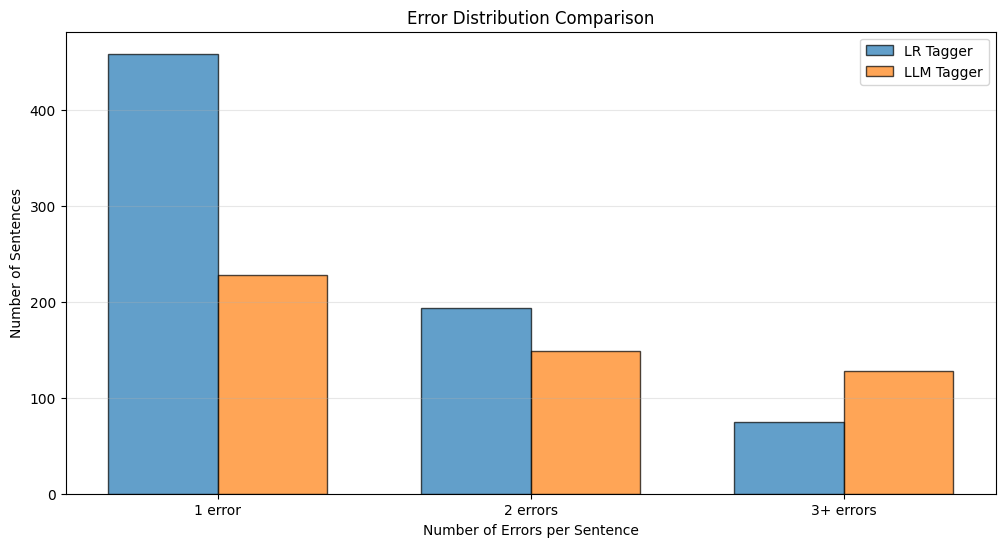

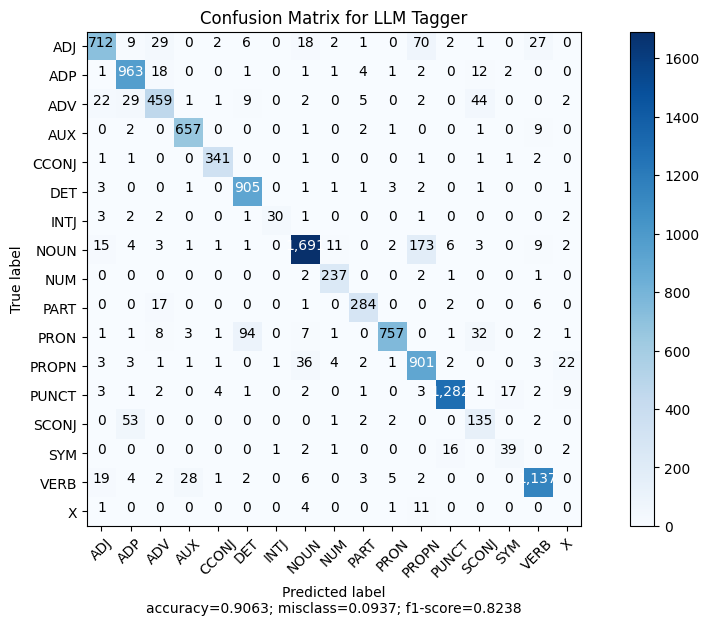

In [63]:
print("Token-level metrics for LLM Tagger:")
print(f"Accuracy: {llm_metrics['accuracy']:.4f}")
print(f"F1 Macro: {llm_metrics['f1_macro']:.4f}")

# Detailed Classification Report for the full dataset
print("\nDetailed Classification Report:")
print(llm_metrics['classification_report'])

# Compare errors between LR and LLM taggers on the full dataset
error_comparison = compare_tagger_errors(filtered_hard_sentences, llm_results)
print(f"\nErrors fixed by LLM: {error_comparison['fixed_by_llm']}")
print(f"New errors introduced by LLM: {error_comparison['new_errors_by_llm']}")
print(f"Errors made by both taggers: {error_comparison['common_errors']}")

# Analyze sentence-level errors
lr_errors, llm_errors = analyze_sentence_errors(filtered_hard_sentences, llm_results)

# Generate confusion matrix
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(llm_results['gold_tags'], normalized_llm_predictions)
plot_confusion_matrix(
    llm_metrics['f1_macro'], 
    cnf_matrix, 
    target_names=classes, 
    title='Confusion Matrix for LLM Tagger', 
    normalize=False
)

# Detailed report on which tokens LLM fixed vs. introduced errors
print("\n=== Top tokens where LLM fixed LR errors ===")
token_fixes = collections.Counter([word for word, _, _, _ in error_comparison['error_tokens']['fixed']])
for token, count in token_fixes.most_common(10):
    print(f"'{token}': fixed {count} times")

print("\n=== Top tokens where LLM introduced new errors ===")
token_errors = collections.Counter([word for word, _, _, _ in error_comparison['error_tokens']['new']])
for token, count in token_errors.most_common(10):
    print(f"'{token}': {count} new errors")

#### How many of the Logistic Regression Tagger errors are fixed by the LLM Tagger

In [64]:
print(f"Total LR errors in the evaluation set: {sum(lr_errors)}")
print(f"Errors fixed by LLM: {error_comparison['fixed_by_llm']}")
print(f"Error fix rate: {error_comparison['fixed_by_llm']/sum(lr_errors):.2%}")

Total LR errors in the evaluation set: 1072
Errors fixed by LLM: 126
Error fix rate: 11.75%


### How many errors are made by the LLM Tagger that were not made by the Logistic Regression Tagger


In [65]:
# How many errors are made by the LLM Tagger that were not made by the Logistic Regression Tagger
print(f"New errors introduced by LLM (on correctly tagged tokens): {error_comparison['new_errors_by_llm']}")

# Calculate the percentage of tokens where LLM introduced new errors
total_tokens = llm_results['total_tokens']
print(f"Total tokens evaluated: {total_tokens}")
print(f"Percentage of tokens with new errors: {error_comparison['new_errors_by_llm']/total_tokens:.2%}")

# Calculate what percentage these new errors represent of the correctly tagged tokens by LR
correct_lr_predictions = total_tokens - sum(lr_errors)
print(f"Total tokens correctly tagged by LR: {correct_lr_predictions}")
print(f"New error rate (relative to correctly tagged tokens): {error_comparison['new_errors_by_llm']/correct_lr_predictions:.2%}")

# Show the most common tokens where LLM introduced errors
print("\n=== Most common tokens where LLM introduced new errors ===")
for token, count in token_errors.most_common(10):
    print(f"'{token}': {count} new errors")

# Analyze tag confusion patterns in new errors
print("\n=== Most common tag confusions in new LLM errors ===")
tag_confusions = collections.Counter()
for word, gold, lr, llm in error_comparison['error_tokens']['new']:
    tag_confusions[(gold, llm)] += 1

for (gold, llm), count in tag_confusions.most_common(5):
    print(f"Gold: {gold}, LLM predicted: {llm} - {count} times")

New errors introduced by LLM (on correctly tagged tokens): 160
Total tokens evaluated: 11619
Percentage of tokens with new errors: 1.38%
Total tokens correctly tagged by LR: 10547
New error rate (relative to correctly tagged tokens): 1.52%

=== Most common tokens where LLM introduced new errors ===
'-': 3 new errors
'page': 3 new errors
'this': 2 new errors
'"': 2 new errors
'team': 2 new errors
'.': 2 new errors
'of': 2 new errors
'years': 2 new errors
'in': 2 new errors
'them': 2 new errors

=== Most common tag confusions in new LLM errors ===
Gold: NOUN, LLM predicted: UDPosTag.PROPN - 39 times
Gold: NOUN, LLM predicted: UDPosTag.ADJ - 13 times
Gold: NOUN, LLM predicted: UDPosTag.VERB - 9 times
Gold: ADJ, LLM predicted: UDPosTag.PROPN - 8 times
Gold: PRON, LLM predicted: UDPosTag.DET - 7 times


### Report sentence-level error metrics: show the histogram of hard sentences with 1,2, and more errors using the LLM Tagger. Compare it to the histogram with the Logistic Regression Tagger.

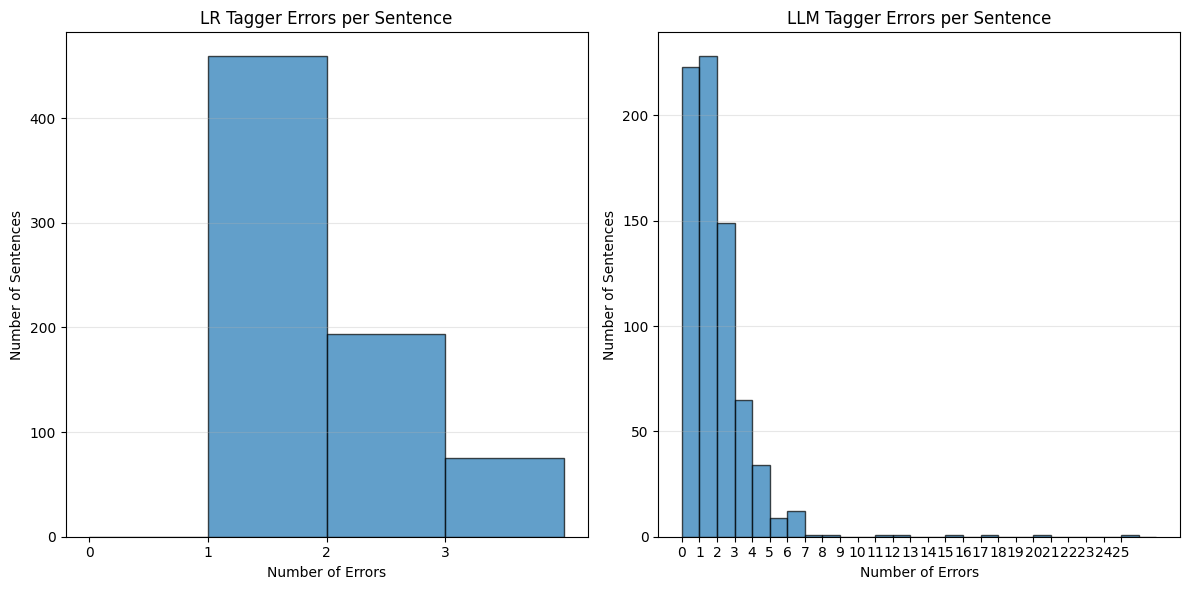

=== Sentence-Level Error Metrics ===
Total sentences evaluated: 728

Logistic Regression Tagger:
Average errors per sentence: 1.47
Median errors per sentence: 1.00
Sentences with 0 errors: 0 (0.0%)
Sentences with 1 error: 459 (63.0%)
Sentences with 2 errors: 194 (26.6%)
Sentences with 3 or more errors: 75 (10.3%)

LLM Tagger:
Average errors per sentence: 1.50
Median errors per sentence: 1.00
Sentences with 0 errors: 223 (30.6%)
Sentences with 1 error: 228 (31.3%)
Sentences with 2 errors: 149 (20.5%)
Sentences with 3 or more errors: 128 (17.6%)

=== Error Improvement Analysis ===
Sentences where LLM reduced errors: 329 (45.2%)
Sentences where LLM increased errors: 217 (29.8%)
Sentences with unchanged error count: 182 (25.0%)


In [66]:
# Generate a histogram comparing error distributions between LR and LLM taggers
plt.figure(figsize=(12, 6))

# LR Tagger errors histogram
plt.subplot(1, 2, 1)
plt.hist(lr_errors, bins=range(0, max(lr_errors)+2), alpha=0.7, edgecolor='black')
plt.title('LR Tagger Errors per Sentence')
plt.xlabel('Number of Errors')
plt.ylabel('Number of Sentences')
plt.grid(axis='y', alpha=0.3)
plt.xticks(range(0, max(lr_errors)+1))

# LLM Tagger errors histogram
plt.subplot(1, 2, 2)
plt.hist(llm_errors, bins=range(0, max(max(llm_errors) + 1, 1)+2), alpha=0.7, edgecolor='black')
plt.title('LLM Tagger Errors per Sentence')
plt.xlabel('Number of Errors')
plt.ylabel('Number of Sentences')
plt.grid(axis='y', alpha=0.3)
plt.xticks(range(0, max(llm_errors)+1))

plt.tight_layout()
plt.show()

# Calculate and display error distribution statistics
import numpy as np

print("=== Sentence-Level Error Metrics ===")
print(f"Total sentences evaluated: {len(lr_errors)}")

# LR error distribution
print("\nLogistic Regression Tagger:")
print(f"Average errors per sentence: {np.mean(lr_errors):.2f}")
print(f"Median errors per sentence: {np.median(lr_errors):.2f}")  # Updated to .2f for more precision
print(f"Sentences with 0 errors: {sum(1 for e in lr_errors if e == 0)} ({sum(1 for e in lr_errors if e == 0)/len(lr_errors):.1%})")
print(f"Sentences with 1 error: {sum(1 for e in lr_errors if e == 1)} ({sum(1 for e in lr_errors if e == 1)/len(lr_errors):.1%})")
print(f"Sentences with 2 errors: {sum(1 for e in lr_errors if e == 2)} ({sum(1 for e in lr_errors if e == 2)/len(lr_errors):.1%})")
print(f"Sentences with 3 or more errors: {sum(1 for e in lr_errors if e >= 3)} ({sum(1 for e in lr_errors if e >= 3)/len(lr_errors):.1%})")

# LLM error distribution
print("\nLLM Tagger:")
print(f"Average errors per sentence: {np.mean(llm_errors):.2f}")
print(f"Median errors per sentence: {np.median(llm_errors):.2f}")  # Updated to .2f for more precision
print(f"Sentences with 0 errors: {sum(1 for e in llm_errors if e == 0)} ({sum(1 for e in llm_errors if e == 0)/len(llm_errors):.1%})")
print(f"Sentences with 1 error: {sum(1 for e in llm_errors if e == 1)} ({sum(1 for e in llm_errors if e == 1)/len(llm_errors):.1%})")
print(f"Sentences with 2 errors: {sum(1 for e in llm_errors if e == 2)} ({sum(1 for e in llm_errors if e == 2)/len(llm_errors):.1%})")
print(f"Sentences with 3 or more errors: {sum(1 for e in llm_errors if e >= 3)} ({sum(1 for e in llm_errors if e >= 3)/len(llm_errors):.1%})")

# Compare and show error improvement/degradation
print("\n=== Error Improvement Analysis ===")
improvements = [lr - llm for lr, llm in zip(lr_errors, llm_errors)]
print(f"Sentences where LLM reduced errors: {sum(1 for i in improvements if i > 0)} ({sum(1 for i in improvements if i > 0)/len(improvements):.1%})")
print(f"Sentences where LLM increased errors: {sum(1 for i in improvements if i < 0)} ({sum(1 for i in improvements if i < 0)/len(improvements):.1%})")
print(f"Sentences with unchanged error count: {sum(1 for i in improvements if i == 0)} ({sum(1 for i in improvements if i == 0)/len(improvements):.1%})")

### Make hypotheses about what cases are difficult for the LLM Tagger and create new sentences that make it fail.
he LLM tagger struggles with syntactically ambiguous constructions where the same word serves multiple grammatical functions within close proximity. 

These ambiguities require deep understanding of hierarchical sentence structure rather than just local context, particularly with function words like "that," "as," and "like" that can operate across different syntactic categories.

The model also has difficulty with specialized lexical ambiguities where normal syntactic expectations are violated or subverted. 
This includes cases where words can function as multiple parts of speech depending on their semantic role, and where idiomatic expressions or domain-specific terminology alters the expected syntactic patterns.

For example:

#### Like
In the sentence "which burger chain do you think is as good as in n out or better in the chicago area besides five guys and smashburger?", "like" is misclassified as ADP (preposition) instead of INTJ (interjection) when used as a discourse marker.

In "which is the best burger chain in the chicago metro area like for example burger king portillo s white castle...", "like" is incorrectly tagged as ADP (preposition) instead of INTJ (interjection) when it's being used to introduce examples conversationally.

#### The
While "the" is typically straightforward as a determiner (DET), in specialized contexts like product names, the tagger struggles. In "I've been looking at the bose sound dock 10", the tagger fails to recognize "the bose sound dock" as a complete product name, tagging "bose" and "sound dock" as common nouns (NOUN) rather than proper nouns (PROPN).

#### As
In "It does n't change the company 's intrinsic worth, and as the article notes...", "as" is incorrectly tagged as ADP (preposition) instead of SCONJ (subordinating conjunction) when introducing a subordinate clause.


### Difficult sentences for the LLM-tagger
1. The WebSurfs blog post about Technology and Arts featured Ice Cream recipes that many like as the best in the world.

2. CEO Smith announced that ONLINE MANAGEMENT would be working as consultants for Green Energy Purchase Agreement through September.

3. Angel fish swimming through the tank like tiny rainbows as the power stays on through the night.

4. That draft opinion was filed with the Court, which noted that Parts I through IV were joined by STEVENS.

5. The sound system has a mini dial that stops working as in when switched to "on" but does not respond.


## Error Explanation and Synthetic Data
Given a set of errors that are made by the taggers (both the LR and the LLM one), and a definition of the POS tagging task, we want to exploit knowledge in the LLM to explain what can be the cause of observed tagging errors.

In [67]:
def collect_error_explanations_with_retry(hard_sentences, batch_size=5, max_retries=5, 
                                          initial_backoff=4, max_sentences=None):
    """
    Collect explanations for POS tagging errors with robust error handling and rate limiting.
    
    Args:
        hard_sentences: List of tuples (tagged_sentence, num_errors, predicted_tags)
        batch_size: Number of sentences to process in each batch
        max_retries: Maximum number of retry attempts
        initial_backoff: Initial backoff time in seconds
        max_sentences: Maximum number of sentences to process (None for all)
        
    Returns:
        List of dicts, each containing a sentence and its error explanations
    """
    import time
    from ud_pos_tagger_gemini import build_error_explanation_prompt, extract_json_from_llm_response
    
    # Initialize variables
    explanations_list = []
    
    # Determine how many sentences to process
    sentences_to_process = hard_sentences[:max_sentences] if max_sentences else hard_sentences
    total_sentences = len(sentences_to_process)
    
    print(f"Processing {total_sentences} sentences in batches of {batch_size}...")
    
    # Process sentences in batches
    for batch_start in range(0, total_sentences, batch_size):
        batch_end = min(batch_start + batch_size, total_sentences)
        batch = sentences_to_process[batch_start:batch_end]
        
        print(f"\nProcessing batch {batch_start//batch_size + 1} (sentences {batch_start+1}-{batch_end})...")
        
        # Process each sentence in the batch
        for idx, (tagged_sentence, num_errors, predicted_tags) in enumerate(batch):
            global_idx = batch_start + idx
            tokens = [w for w, _ in tagged_sentence]
            correct_tags = [t for _, t in tagged_sentence]
            sentence_text = " ".join(tokens)
            
            print(f"  Processing sentence {global_idx+1}/{total_sentences}: {sentence_text[:50]}{'...' if len(sentence_text) > 50 else ''}")
            
            # Build the prompt
            prompt = build_error_explanation_prompt(sentence_text, tokens, correct_tags, predicted_tags)
            
            # Initialize retry variables
            retry_count = 0
            success = False
            
            # Retry loop
            while retry_count <= max_retries and not success:
                try:
                    # Add backoff if this is a retry
                    if retry_count > 0:
                        backoff_time = initial_backoff * (2 ** (retry_count - 1))
                        print(f"    Retry {retry_count}/{max_retries}, waiting {backoff_time}s...")
                        time.sleep(backoff_time)
                    
                    # Use the imported function from ud_pos_tagger_gemini to generate explanations
                    explanations = []
                    
                    # Call the function to get error explanations
                    # We'll use the extract_json_from_llm_response function after getting the response from
                    # the collect_llm_error_explanations function that should be in ud_pos_tagger_gemini
                    from ud_pos_tagger_gemini import collect_llm_error_explanations
                    llm_response = collect_llm_error_explanations([(tagged_sentence, num_errors, predicted_tags)])
                    
                    # Process the response
                    if llm_response:
                        explanations_list.append({
                            "sentence": sentence_text,
                            "explanations": llm_response[0]["explanations"] if llm_response[0]["explanations"] else []
                        })
                        
                        # Print a short summary
                        print(f"    ✓ Found {len(llm_response[0]['explanations']) if 'explanations' in llm_response[0] else 0} error explanations")
                        success = True
                    else:
                        raise Exception("Failed to get explanations from LLM")
                        
                except Exception as e:
                    retry_count += 1
                    print(f"    Error: {str(e)}")
                    if retry_count > max_retries:
                        print(f"    ✗ Failed to process sentence after {max_retries} retries")
                        # Add empty explanations to maintain indexing
                        explanations_list.append({
                            "sentence": sentence_text,
                            "explanations": []
                        })
            
            # Short pause between sentences to avoid rate limits
            if idx < len(batch) - 1:
                time.sleep(1)
        
        # Add a pause between batches to avoid rate limits
        if batch_end < total_sentences:
            time.sleep(5)
    
    print(f"\nCompleted processing {len(explanations_list)} sentences.")
    return explanations_list

In [68]:
# Check if we already have saved error explanations
import os
import pickle

error_explanations_file = 'error_explanations.pkl'

if os.path.exists(error_explanations_file):
    print(f"Loading existing error explanations from {error_explanations_file}")
    with open(error_explanations_file, 'rb') as f:
        error_explanations = pickle.load(f)
else:
    print("No existing error explanations found. Collecting new explanations...")
    # Collect explanations with robust error handling
    error_explanations = collect_error_explanations_with_retry(
        filtered_hard_sentences,  
        batch_size=5,             # Process 5 sentences at a time
        max_retries=5,            # Retry up to 5 times per sentence
        initial_backoff=4,        # Start with 4 second backoff
    )

    # Save results to avoid reprocessing
    with open(error_explanations_file, 'wb') as f:
        pickle.dump(error_explanations, f)

# Print the first explanation as an example
if error_explanations and error_explanations[0]['explanations']:
    print("\nSample explanation:")
    print(json.dumps(error_explanations[0]['explanations'][0], indent=2))

Loading existing error explanations from error_explanations.pkl

Sample explanation:
{
  "word": "wares",
  "correct_tag": "NOUN",
  "predicted_tag": "VERB",
  "explanation": "The word 'wares' is used as a noun here, referring to products or services. The tagger likely misinterprets it due to the potential for the verb form (e.g., 'wears').",
  "category": "Lexical Ambiguity: NOUN/VERB"
}


In [69]:
print(error_explanations[0])

{'sentence': 'What if Google expanded on its search - engine ( and now e-mail ) wares into a full - fledged operating system ?', 'explanations': [{'word': 'wares', 'correct_tag': 'NOUN', 'predicted_tag': 'VERB', 'explanation': "The word 'wares' is used as a noun here, referring to products or services. The tagger likely misinterprets it due to the potential for the verb form (e.g., 'wears').", 'category': 'Lexical Ambiguity: NOUN/VERB'}, {'word': 'full', 'correct_tag': 'ADJ', 'predicted_tag': 'ADV', 'explanation': "The word 'full' is used to describe 'fledged' and 'operating system'. The tagger incorrectly tags it as an adverb, likely because it can sometimes function as an adverb (e.g., 'filled full').", 'category': 'Lexical Ambiguity: ADJ/ADV'}, {'word': 'fledged', 'correct_tag': 'ADJ', 'predicted_tag': 'VERB', 'explanation': "The word 'fledged' is an adjective modifying 'operating system', describing its maturity/status. The tagger mistakes it for a verb, potentially because it has 

### Get all the explanations


In [70]:
# Create a flat list of all explanations from all sentences
all_explanations = []
for sentence_data in error_explanations:
    if 'explanations' in sentence_data and sentence_data['explanations']:
        all_explanations.extend(sentence_data['explanations'])

# Print summary statistics
print(f"Total explanations collected: {len(all_explanations)}")

# Print the distribution of error categories
from collections import Counter
category_counts = Counter([exp['category'] for exp in all_explanations])
print("\nError category distribution:")
for category, count in category_counts.most_common():
    print(f"  {category}: {count}")

# Print a few sample explanations
if all_explanations:
    print("\nSample explanations:")
    for i, exp in enumerate(all_explanations[:3]):
        print(f"\nExample {i+1}:")
        print(f"Word: '{exp['word']}'")
        print(f"Correct: {exp['correct_tag']} | Predicted: {exp['predicted_tag']}")
        print(f"Category: {exp['category']}")
        print(f"Explanation: {exp['explanation']}")

Total explanations collected: 1109

Error category distribution:
  Named Entity Error: PROPN/NOUN: 197
  Contextual Misinterpretation: NOUN/PROPN: 43
  Contextual Misinterpretation: ADJ/NOUN: 34
  Lexical Ambiguity: ADJ/NOUN: 32
  Lexical Ambiguity: NOUN/VERB: 31
  Named Entity Error: NOUN/PROPN: 29
  Contextual Misinterpretation: ADJ/ADV: 29
  Lexical Ambiguity: VERB/NOUN: 28
  Contextual Misinterpretation: VERB/NOUN: 27
  Contextual Misinterpretation: ADP/SCONJ: 27
  Contextual Misinterpretation: ADP/ADV: 25
  Named Entity Error: PROPN/ADJ: 25
  Contextual Misinterpretation: AUX/VERB: 25
  Contextual Misinterpretation: NOUN/VERB: 21
  Contextual Misinterpretation: ADV/ADJ: 18
  Contextual Misinterpretation: ADV/ADP: 17
  Contextual Misinterpretation: PROPN/NOUN: 17
  Contextual Misinterpretation: ADJ/VERB: 16
  Contextual Misinterpretation: SCONJ/ADP: 14
  Contextual Misinterpretation: NOUN/ADJ: 13
  Contextual Misinterpretation: VERB/ADJ: 12
  Named Entity Error: PROPN/C: NOUN: 11
 

### Get all the error categories


In [71]:
# First get all unique error categories
unique_categories = set(exp['category'] for exp in all_explanations)
print(f"Found {len(unique_categories)} unique error categories")

# Create a dictionary to group explanations by category
explanations_by_category = {}
for exp in all_explanations:
    category = exp['category']
    if category not in explanations_by_category:
        explanations_by_category[category] = []
    explanations_by_category[category].append(exp)

# Print details for each category
print("\n=== Error Categories Analysis ===")
for category, exps in sorted(explanations_by_category.items(), key=lambda x: len(x[1]), reverse=True):
    print(f"\n## {category} ({len(exps)} errors)")
    
    # Count tag patterns within this category
    tag_patterns = Counter([f"{exp['correct_tag']} → {exp['predicted_tag']}" for exp in exps])
    print("Most common tag confusion patterns:")
    for pattern, count in tag_patterns.most_common(3):
        print(f"  {pattern}: {count} times")
    
    # Show common words in this category
    word_counts = Counter([exp['word'] for exp in exps])
    print("Most frequently misclassified words:")
    for word, count in word_counts.most_common(5):
        print(f"  '{word}': {count} times")
    
    # Show an example
    if exps:
        example = exps[0]
        print("\nExample explanation:")
        print(f"Word: '{example['word']}'")
        print(f"Correct tag: {example['correct_tag']} | Predicted tag: {example['predicted_tag']}")
        print(f"Explanation: {example['explanation']}")

Found 210 unique error categories

=== Error Categories Analysis ===

## Named Entity Error: PROPN/NOUN (197 errors)
Most common tag confusion patterns:
  PROPN → NOUN: 192 times
  PROPN → C: PROPN    P: NOUN: 2 times
  PROPN → C: NOUN: 1 times
Most frequently misclassified words:
  'HPL': 4 times
  'Comets': 4 times
  'tmobile': 4 times
  'Securities': 3 times
  'EB3326': 3 times

Example explanation:
Word: 'BREYER'
Correct tag: PROPN | Predicted tag: NOUN
Explanation: The word 'BREYER' is a proper noun (a last name), likely misclassified because the model might not have encountered it frequently or recognized it as a name, especially given its initial capitalization.

## Contextual Misinterpretation: NOUN/PROPN (43 errors)
Most common tag confusion patterns:
  NOUN → PROPN: 42 times
  NOUN → C: PROPN: 1 times
Most frequently misclassified words:
  'blogger': 1 times
  'magazine': 1 times
  'Resolution': 1 times
  'AMS': 1 times
  'fascists': 1 times

Example explanation:
Word: 'blogg

### Use the LLM to generate examples of hard sentences that include 2 to 3 instances of the error categories.
Extract Top Error Categories and Their Characteristics

In [72]:
def get_error_categories(explanations_by_category, top_n=None):
    """
    Get error categories by frequency.
    
    Args:
        explanations_by_category: Dictionary mapping categories to explanations
        top_n: Number of top categories to return (None for all categories)
        
    Returns:
        List of category details ordered by frequency
    """
    # Sort categories by number of examples
    sorted_categories = sorted(explanations_by_category.items(), 
                               key=lambda x: len(x[1]), 
                               reverse=True)
    
    # Select categories (all if top_n is None, otherwise top N)
    if top_n is not None:
        selected_categories = sorted_categories[:top_n]
    else:
        selected_categories = sorted_categories
    
    # For each category, collect example words and tag patterns
    category_details = []
    for category, examples in selected_categories:
        # Get most common words in this category
        word_counts = Counter([ex['word'] for ex in examples])
        common_words = [word for word, _ in word_counts.most_common(5)]
        
        # Get most common tag confusion patterns
        tag_patterns = Counter([f"{ex['correct_tag']} → {ex['predicted_tag']}" for ex in examples])
        common_patterns = [pattern for pattern, _ in tag_patterns.most_common(3)]
        
        # Get a representative example
        example = examples[0] if examples else None
        
        category_details.append({
            'category': category,
            'example_count': len(examples),
            'common_words': common_words,
            'tag_patterns': common_patterns,
            'example': example
        })
    
    return category_details

Create a Prompt for Hard Sentence Generation

In [73]:
def build_hard_sentence_generation_prompt(category_details, num_sentences=5):
    """Build a prompt for generating hard sentences with specific error categories."""
    
    # Start with an explanation of the task
    prompt = """You are a linguistics expert specializing in part-of-speech tagging.

I need you to generate challenging sentences that would be difficult for automatic POS taggers to correctly analyze. Each sentence should include 2-3 instances of the error categories described below.

Universal Dependencies POS Tags:
ADJ: adjective
ADP: adposition (preposition, postposition)
ADV: adverb
AUX: auxiliary verb
CCONJ: coordinating conjunction
DET: determiner
INTJ: interjection
NOUN: noun
NUM: numeral
PART: particle
PRON: pronoun
PROPN: proper noun
PUNCT: punctuation
SCONJ: subordinating conjunction
SYM: symbol
VERB: verb
X: other

Error categories that are particularly challenging:
"""
    
    # Add details for each selected category
    for details in category_details:
        prompt += f"\n## {details['category']} ({details['example_count']} instances)\n"
        
        # Add example words
        prompt += "Common problematic words: " + ", ".join(f"'{word}'" for word in details['common_words']) + "\n"
        
        # Add tag patterns
        prompt += "Common tag confusions: " + ", ".join(details['tag_patterns']) + "\n"
        
        # Add an example if available
        if details['example']:
            ex = details['example']
            prompt += f"Example: The word '{ex['word']}' should be tagged as {ex['correct_tag']} but is often incorrectly tagged as {ex['predicted_tag']}.\n"
            prompt += f"Explanation: {ex['explanation']}\n"
    
    # Add instructions for the output format
    prompt += f"""
Please generate {num_sentences} challenging sentences that each contain 2-3 instances of these error categories. For each sentence:
1. Provide the sentence text
2. Identify 2-3 words that exemplify the error categories
3. For each identified word, indicate:
   - The correct POS tag
   - The likely incorrect tag a tagger might assign
   - The error category it represents
   - A brief explanation of why this is challenging

Format your response as a JSON array of sentence objects. For example:
```json
[
  {{
    "sentence": "Like many others, he felt like giving up on the project that like-minded people had started.",
    "challenges": [
      {{
        "word": "Like",
        "position": 0,
        "correct_tag": "ADP",
        "likely_wrong_tag": "VERB",
        "category": "Lexical Ambiguity: ADP/VERB",
        "explanation": "Sentence-initial 'Like' is a preposition here, but can often be confused with the verb form."
      }},
      ...
    ]
  }},
  ...
]
Be creative and make the sentences natural while deliberately incorporating these challenging patterns. """
    return prompt


In [74]:
def generate_hard_sentences_with_random_categories(explanations_by_category, num_sentences=10, 
                                                  max_retries=6, initial_backoff=4):
    """
    Generate hard sentences by randomly selecting different error categories.
    """
    import random
    import time
    import math
    # Import the API function from ud_pos_tagger_gemini
    from ud_pos_tagger_gemini import generate_hard_sentences_api
    
    all_generated_sentences = []
    categories_list = list(explanations_by_category.keys())
    
    # Calculate how many batches we need (each generating 5 sentences)
    num_batches = math.ceil(num_sentences / 5)
    
    print(f"Generating {num_sentences} hard sentences in {num_batches} batches...")
    
    for batch in range(num_batches):
        # Randomly select 2 or 3 categories for this batch
        num_categories = random.choice([2, 3])
        if len(categories_list) < num_categories:
            selected_categories = categories_list  # Use all if we have fewer categories than needed
        else:
            selected_categories = random.sample(categories_list, num_categories)
        
        print(f"\nBatch {batch+1}/{num_batches}: Using {num_categories} random categories")
        for cat in selected_categories:
            print(f"- {cat}")
        
        # Extract details for selected categories
        selected_category_details = []
        for category in selected_categories:
            examples = explanations_by_category[category]
            
            # Get common words
            from collections import Counter
            word_counts = Counter([ex['word'] for ex in examples])
            common_words = [word for word, _ in word_counts.most_common(5)]
            
            # Get tag patterns
            tag_patterns = Counter([f"{ex['correct_tag']} → {ex['predicted_tag']}" for ex in examples])
            common_patterns = [pattern for pattern, _ in tag_patterns.most_common(3)]
            
            # Get a representative example
            example = examples[0] if examples else None
            
            selected_category_details.append({
                'category': category,
                'example_count': len(examples),
                'common_words': common_words,
                'tag_patterns': common_patterns,
                'example': example
            })
        
        # Build prompt for these categories
        prompt = build_hard_sentence_generation_prompt(selected_category_details, num_sentences=5)
        
        # Try to generate sentences with retries
        retry_count = 0
        success = False
        
        while retry_count <= max_retries and not success:
            try:
                if retry_count > 0:
                    backoff_time = initial_backoff * (2 ** (retry_count - 1))
                    print(f"Retry {retry_count}/{max_retries}, waiting {backoff_time}s...")
                    time.sleep(backoff_time)
                
                # Use the imported function instead of direct API calls
                batch_sentences = generate_hard_sentences_api(prompt, max_retries, initial_backoff)
                
                if batch_sentences:
                    # Add to our collection
                    all_generated_sentences.extend(batch_sentences)
                    print(f"Successfully generated {len(batch_sentences)} sentences in this batch")
                    
                    # Print a sample sentence
                    if batch_sentences:
                        sample = batch_sentences[0]
                        print(f"Sample: \"{sample['sentence']}\"")
                        print(f"With {len(sample['challenges'])} challenges")
                    
                    success = True
                else:
                    raise Exception("API call failed to return valid sentences")
                    
            except Exception as e:
                retry_count += 1
                print(f"Error in batch {batch+1}: {str(e)}")
                if retry_count > max_retries:
                    print(f"Failed to generate sentences for batch {batch+1} after {max_retries} retries")
        
        # Add a pause between batches
        if batch < num_batches - 1:
            time.sleep(5)
    
    # Trim to the requested number of sentences
    return all_generated_sentences[:num_sentences] if len(all_generated_sentences) > num_sentences else all_generated_sentences

Generate Hard Sentences Using the LLM API

In [75]:
def generate_hard_sentences(category_details, num_sentences=10, max_retries=6, initial_backoff=4):
    """
    Generate hard sentences using the Gemini API with retry capability.
    """
    import time
    # Import the API function from ud_pos_tagger_gemini
    from ud_pos_tagger_gemini import generate_hard_sentences_api
    
    # Build the prompt
    prompt = build_hard_sentence_generation_prompt(category_details, num_sentences)
    
    # Try to generate sentences with retries
    retry_count = 0
    success = False
    
    while retry_count <= max_retries and not success:
        try:
            if retry_count > 0:
                backoff_time = initial_backoff * (2 ** (retry_count - 1))
                print(f"Retry {retry_count}/{max_retries}, waiting {backoff_time}s...")
                time.sleep(backoff_time)
            
            # Use the imported function instead of direct API calls
            sentences = generate_hard_sentences_api(prompt, max_retries, initial_backoff)
            
            if sentences:
                print(f"Successfully generated {len(sentences)} sentences")
                return sentences
            else:
                raise Exception("Failed to generate sentences")
                
        except Exception as e:
            retry_count += 1
            print(f"Error: {str(e)}")
            if retry_count > max_retries:
                print(f"Failed to generate sentences after {max_retries} retries")
                return None
    
    return None

Run the Code and Save the Results

In [76]:
def run_hard_sentence_generation(all_explanations, explanations_by_category, num_sentences=20, 
                                max_retries=6, initial_backoff=4):
    """
    Run the complete hard sentence generation process and save results.
    
    Args:
        all_explanations: List of all error explanations
        explanations_by_category: Dictionary mapping categories to explanations
        num_sentences: Number of sentences to generate
        max_retries: Maximum number of retry attempts
        initial_backoff: Initial backoff time in seconds
        
    Returns:
        List of generated hard sentences with their challenges
    """
    import json
    import os
    from datetime import datetime
    
    # Print summary of available categories
    print(f"\nUsing {len(explanations_by_category)} error categories for random selection:")
    for i, (category, examples) in enumerate(sorted(explanations_by_category.items(), 
                                                  key=lambda x: len(x[1]), 
                                                  reverse=True)[:10]):  # Show top 10
        print(f"- {category} ({len(examples)} instances)")
    
    if len(explanations_by_category) > 10:
        print(f"... and {len(explanations_by_category) - 10} more categories")
    
    # Generate sentences with random category selection
    print(f"\nGenerating {num_sentences} hard sentences with random category combinations...")
    sentences = generate_hard_sentences_with_random_categories(
        explanations_by_category,  # Use the raw category dictionary instead of processed details
        num_sentences=num_sentences,
        max_retries=max_retries,
        initial_backoff=initial_backoff
    )
    
    if sentences:
        print(f"\nSuccessfully generated {len(sentences)} hard sentences")
        
        # Save to file with error handling
        try:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"generated_hard_sentences_{timestamp}.json"
            
            with open(filename, 'w') as f:
                json.dump(sentences, f, indent=2)
            
            print(f"Saved sentences to {filename}")
        except Exception as e:
            print(f"Error saving sentences to file: {e}")
            # Create a backup file if primary save fails
            try:
                backup_filename = f"generated_hard_sentences_backup_{timestamp}.json"
                with open(backup_filename, 'w') as f:
                    json.dump(sentences, f)
                print(f"Saved backup to {backup_filename}")
            except:
                print("Failed to save backup file as well")
        
        # Print a few examples
        print("\nSample generated sentences:")
        for i, sentence in enumerate(sentences[:3]):
            print(f"\nSentence {i+1}: {sentence['sentence']}")
            print("Challenges:")
            for challenge in sentence['challenges']:
                print(f"  - '{challenge['word']}': {challenge['correct_tag']} often confused with {challenge['likely_wrong_tag']}")
                print(f"    Category: {challenge['category']}")
                print(f"    Explanation: {challenge['explanation'][:100]}..." if len(challenge['explanation']) > 100 else challenge['explanation'])
    else:
        print("Failed to generate sentences after multiple retries")
    
    return sentences

Main Execution

In [77]:
# Check if we already have saved hard sentences
import os
import json
from collections import Counter
from datetime import datetime

hard_sentences_file = 'generated_hard_sentences.json'
number_of_sentences_to_generate = 250

try:
    if os.path.exists(hard_sentences_file):
        print(f"Loading existing hard sentences from {hard_sentences_file}")
        with open(hard_sentences_file, 'r') as f:
            hard_sentences = json.load(f)
    else:
        print("Generating new hard sentences...")
        # Pass the retry parameters for consistency with other functions
        hard_sentences = run_hard_sentence_generation(
            all_explanations, 
            explanations_by_category, 
            num_sentences=number_of_sentences_to_generate,
            max_retries=5,
            initial_backoff=4
        )
        
        # Save results with error handling
        if hard_sentences:
            try:
                with open(hard_sentences_file, 'w') as f:
                    json.dump(hard_sentences, f, indent=2)
                print(f"Saved hard sentences to {hard_sentences_file}")
            except Exception as e:
                print(f"Error saving to primary file: {e}")
                # Create backup file with timestamp
                try:
                    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                    backup_file = f"hard_sentences_backup_{timestamp}.json"
                    with open(backup_file, 'w') as f:
                        json.dump(hard_sentences, f, indent=2)
                    print(f"Saved backup to {backup_file}")
                except Exception as e2:
                    print(f"Failed to save backup file: {e2}")

    # Display statistics on the generated sentences
    if hard_sentences:
        # Count categories represented
        categories_used = []
        for sentence in hard_sentences:
            for challenge in sentence['challenges']:
                categories_used.append(challenge['category'])
        
        category_counts = Counter(categories_used)
        print("\nDistribution of error categories in generated sentences:")
        for category, count in category_counts.most_common():
            print(f"  {category}: {count} instances")
        
        print(f"\nTotal sentences: {len(hard_sentences)}")
        print(f"Total challenges: {len(categories_used)}")
        print(f"Average challenges per sentence: {len(categories_used)/len(hard_sentences):.2f}")
            
except Exception as e:
    print(f"Error in hard sentence processing: {e}")
    hard_sentences = None

Loading existing hard sentences from generated_hard_sentences.json

Distribution of error categories in generated sentences:
  Contextual Misinterpretation: VERB/AUX: 30 instances
  Contextual Misinterpretation: ADJ/PROPN: 30 instances
  Contextual Misinterpretation: VERB/PROPN: 29 instances
  Lexical Ambiguity: ADV/ADJ: 25 instances
  Contextual Misinterpretation: PRON/VERB: 23 instances
  Contextual Misinterpretation: PROPN/C: NOUN: 23 instances
  Lexical Ambiguity: ADJ/VERB: 21 instances
  Contextual Misinterpretation: ADP/SCONJ: 20 instances
  Capitalization Issue: ADJ/PROPN: 19 instances
  Contextual Misinterpretation: SCONJ/PRON: 15 instances
  Contextual Misinterpretation: INTJ/ADP: 15 instances
  Contextual Misinterpretation: DET/C: ADJ: 15 instances
  Contextual Misinterpretation: NOUN/ADV: 15 instances
  Capitalization Issue: AUX/PROPN: 14 instances
  Contextual Misinterpretation: PART/ADV: 14 instances
  Lexical Ambiguity: INTJ/ADP: 13 instances
  Contextual Misinterpretatio

Add the synthetic data to the training dataset of the LR tagger and re-run training.

In [78]:
# Step 1: Load synthetic sentences 
import json

# Load the generated hard sentences
with open('generated_hard_sentences.json', 'r') as f:
    hard_sentences_json = json.load(f)


In [79]:
# Step 2: Convert synthetic data to the same format as train_sentences
synthetic_sentences = []

for sentence_obj in hard_sentences_json:
    # Extract sentence text
    sentence_text = sentence_obj['sentence']
    
    # Tokenize the sentence
    tokens = nltk.word_tokenize(sentence_text)
    
    # Use LR model to predict tags for all tokens as a starting point
    features = transform_test_sentence(tokens)
    features_vectorized = vec.transform([x[0] for x in features])
    predicted_tags = clf.predict(features_vectorized)
    
    # Create the tagged tokens list
    tagged_tokens = list(zip(tokens, predicted_tags))
    
    # Extract the challenges and update their tags
    for challenge in sentence_obj['challenges']:
        word = challenge['word']
        correct_tag = challenge['correct_tag']
        
        # Find this word in the tokenized sentence
        for i, (token, _) in enumerate(tagged_tokens):
            if token.lower() == word.lower():
                # Replace the tag with the correct one
                tagged_tokens[i] = (token, correct_tag)
                break
    
    # Add the tagged sentence to our list
    synthetic_sentences.append(tagged_tokens)

# Print some statistics
print(f"Number of synthetic sentences created: {len(synthetic_sentences)}")
print(f"Total synthetic tokens: {sum(len(s) for s in synthetic_sentences)}")


Number of synthetic sentences created: 250
Total synthetic tokens: 4764


In [80]:
# Step 3: Add synthetic data to training dataset
combined_train_sentences = train_sentences + val_sentences + synthetic_sentences


In [81]:
# Step 4: Vectorize the synthetic data and combine with original training data
X_synthetic, y_synthetic = transform_to_dataset(synthetic_sentences)
X_synthetic_vec = vec.transform([x[0] for x in X_synthetic])

# Combine all training data
X_train_combined = vstack((X_train, X_val, X_synthetic_vec))
y_train_combined = np.append(y_train, np.append(y_val, y_synthetic))



In [82]:
# Step 5: Re-train the LR model with the combined data
t_ini = datetime.now()
print('Training with synthetic data...')
clf_combined = LogisticRegression(C=20, solver='liblinear', random_state=13)
clf_combined.fit(X_train_combined, y_train_combined)
t_fin = datetime.now()
print(f'Training completed in {(t_fin - t_ini).total_seconds()} seconds')

Training with synthetic data...
Training completed in 394.211549 seconds


In [83]:
# Step 6: Evaluate the new model
y_pred_combined = clf_combined.predict(X_test)
print("Accuracy with synthetic data: {0:.4f}".format(clf_combined.score(X_test, y_test)))
print('F1-macro score with synthetic data: {0:.4f}'.format(f1_score(y_test, y_pred_combined, average='macro')))
print('Classification report with synthetic data:')
print(classification_report(y_test, y_pred_combined, digits=4))

Accuracy with synthetic data: 0.9456
F1-macro score with synthetic data: 0.9031
Classification report with synthetic data:
              precision    recall  f1-score   support

         ADJ     0.9149    0.9052    0.9101      1794
         ADP     0.9342    0.9581    0.9460      2030
         ADV     0.9176    0.8943    0.9058      1183
         AUX     0.9806    0.9831    0.9819      1543
       CCONJ     0.9932    0.9932    0.9932       736
         DET     0.9900    0.9905    0.9902      1896
        INTJ     0.9720    0.8595    0.9123       121
        NOUN     0.9059    0.9178    0.9118      4123
         NUM     0.9761    0.9815    0.9788       542
        PART     0.9769    0.9753    0.9761       649
        PRON     0.9884    0.9871    0.9878      2166
       PROPN     0.8815    0.8603    0.8708      2076
       PUNCT     0.9920    0.9964    0.9942      3096
       SCONJ     0.8626    0.8177    0.8396       384
         SYM     0.8812    0.8165    0.8476       109
        VERB

In [84]:
# Step 7: Compare with original model
y_pred_original = clf.predict(X_test)

print("\nComparison of models:")
print(f"Original model accuracy: {clf.score(X_test, y_test):.4f}")
print(f"Combined model accuracy: {clf_combined.score(X_test, y_test):.4f}")
print(f"Original model F1-macro: {f1_score(y_test, y_pred_original, average='macro'):.4f}")
print(f"Combined model F1-macro: {f1_score(y_test, y_pred_combined, average='macro'):.4f}")

# Calculate improvement
acc_improvement = (clf_combined.score(X_test, y_test) - clf.score(X_test, y_test)) * 100
f1_improvement = (f1_score(y_test, y_pred_combined, average='macro') - 
                 f1_score(y_test, y_pred_original, average='macro')) * 100

print(f"Accuracy improvement: {acc_improvement:.2f}%")
print(f"F1-score improvement: {f1_improvement:.2f}%")


Comparison of models:
Original model accuracy: 0.9448
Combined model accuracy: 0.9456
Original model F1-macro: 0.9020
Combined model F1-macro: 0.9031
Accuracy improvement: 0.08%
F1-score improvement: 0.11%


Perform contrastive error analysis between the two versions of the LR tagger.

In [85]:
# Compare predictions between the two models
diff_indices = [i for i in range(len(y_test)) if y_pred_original[i] != y_pred_combined[i]]

# See how many of these differences fixed errors vs. introduced new errors
fixes = [i for i in diff_indices if y_pred_original[i] != y_test[i] and y_pred_combined[i] == y_test[i]]
new_errors = [i for i in diff_indices if y_pred_original[i] == y_test[i] and y_pred_combined[i] != y_test[i]]

print(f"Number of tokens with different predictions: {len(diff_indices)}")
print(f"Number of errors fixed by the combined model: {len(fixes)}")
print(f"Number of new errors introduced by the combined model: {len(new_errors)}")

# Analyze the types of fixes and new errors
i2w_test = id2word(test_sentences)

if fixes:
    fix_tokens = [i2w_test[i] for i in fixes]
    fix_tag_changes = [(y_pred_original[i], y_pred_combined[i]) for i in fixes]
    fix_counter = collections.Counter(zip(fix_tokens, fix_tag_changes))
    
    print("\nMost common fixes:")
    for (token, (old_tag, new_tag)), count in fix_counter.most_common(10):
        print(f"'{token}': {old_tag} -> {new_tag} ({count} times)")

if new_errors:
    error_tokens = [i2w_test[i] for i in new_errors]
    error_tag_changes = [(y_pred_original[i], y_pred_combined[i]) for i in new_errors]
    error_counter = collections.Counter(zip(error_tokens, error_tag_changes))
    
    print("\nMost common new errors:")
    for (token, (old_tag, new_tag)), count in error_counter.most_common(10):
        print(f"'{token}': {old_tag} -> {new_tag} ({count} times)")

Number of tokens with different predictions: 155
Number of errors fixed by the combined model: 77
Number of new errors introduced by the combined model: 57

Most common fixes:
'to': ADP -> PART (2 times)
'AMS': NOUN -> PROPN (2 times)
'Lest': PROPN -> SCONJ (2 times)
'fledged': VERB -> ADJ (1 times)
'anyways': VERB -> ADV (1 times)
'one': NUM -> NOUN (1 times)
'this': PRON -> DET (1 times)
'tense': NOUN -> ADJ (1 times)
'there': PRON -> ADV (1 times)
'needs': NOUN -> VERB (1 times)

Most common new errors:
'to': PART -> ADP (3 times)
'to': ADP -> PART (2 times)
'/': PUNCT -> SYM (2 times)
'concurring': VERB -> ADJ (1 times)
'with': ADP -> SCONJ (1 times)
'there': PRON -> ADV (1 times)
'preeminent': ADJ -> NOUN (1 times)
'Trade': PROPN -> NOUN (1 times)
'Dick': PROPN -> ADJ (1 times)
'all': ADV -> DET (1 times)


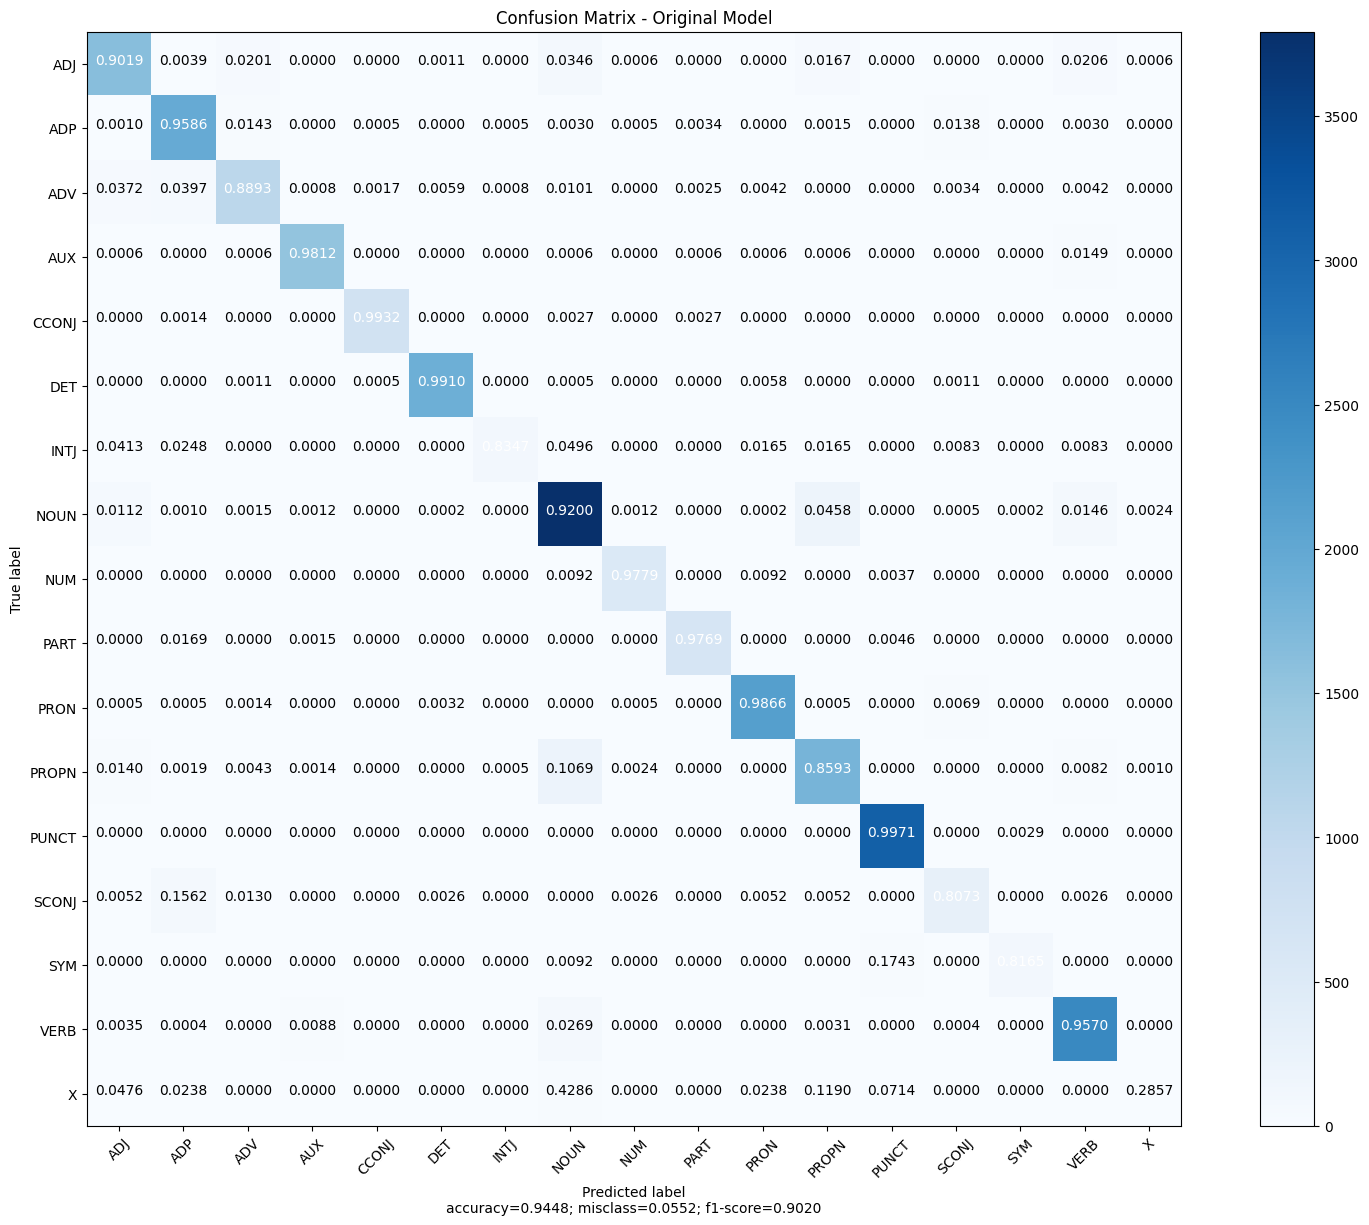

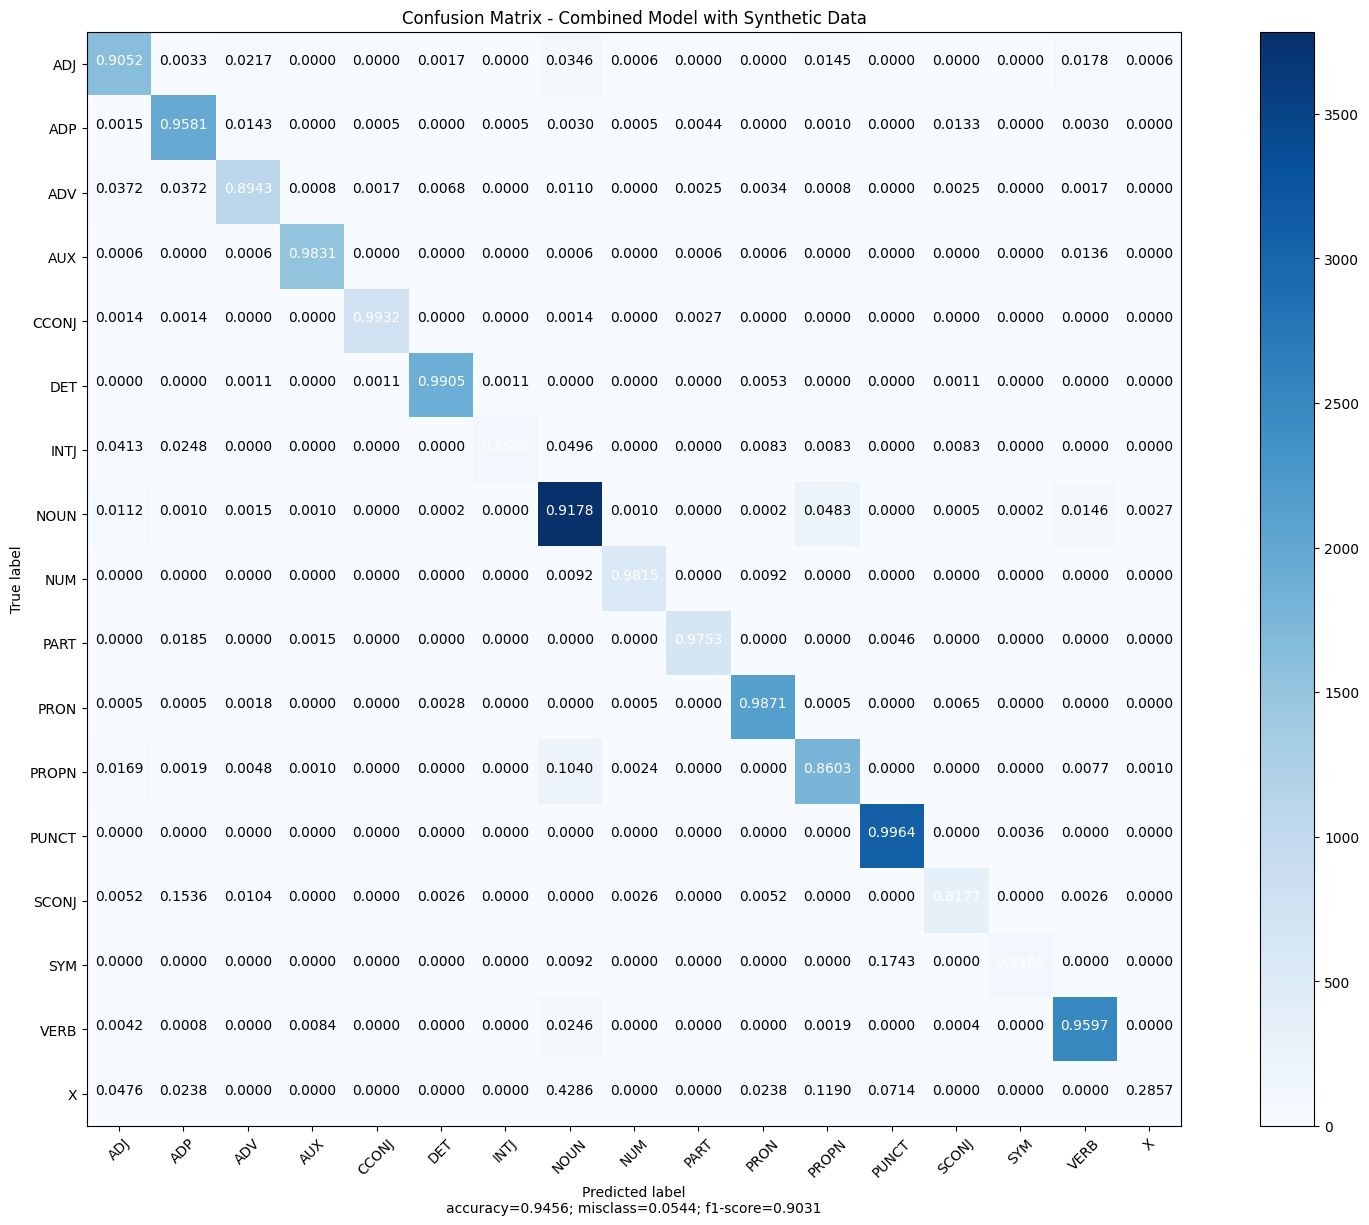

In [86]:
# Set the default figure size larger before plotting
import matplotlib as mpl
original_figsize = mpl.rcParams['figure.figsize']
mpl.rcParams['figure.figsize'] = (16, 12)  # Set to a larger size

# Monkey patch the plt.figure function temporarily
original_figure = plt.figure
def larger_figure(*args, **kwargs):
    kwargs['figsize'] = (16, 12)
    return original_figure(*args, **kwargs)

plt.figure = larger_figure

# Create confusion matrices for both models
cnf_matrix_original = confusion_matrix(y_test, y_pred_original)
cnf_matrix_combined = confusion_matrix(y_test, y_pred_combined)

# Plot matrices
plot_confusion_matrix(
    f1_score(y_test, y_pred_original, average='macro'),
    cnf_matrix_original,
    target_names=classes,
    title='Confusion Matrix - Original Model',
    normalize=True
)

plot_confusion_matrix(
    f1_score(y_test, y_pred_combined, average='macro'),
    cnf_matrix_combined,
    target_names=classes,
    title='Confusion Matrix - Combined Model with Synthetic Data',
    normalize=True
)

# Restore original plt.figure
plt.figure = original_figure

# Restore original figure size
mpl.rcParams['figure.figsize'] = original_figsize

In [87]:
# Evaluate and compare model performance specifically on challenging sentences
# "Hard sentences" are those from the test dataset where the original model made errors
# This analysis helps measure how much the synthetic data improved the model on difficult cases

# Initialize counters to track errors for both models
baseline_lr_model_error_count = 0     # Original model trained only on standard data
synthetic_enhanced_model_error_count = 0  # Enhanced model trained with original + synthetic data
total_tokens_in_difficult_sentences = 0

# Make sure we have difficult sentences to evaluate
if not filtered_hard_sentences:
    print("No difficult sentences found for evaluation")
else:
    # Iterate through each difficult sentence from the test set
    for difficult_sentence, error_count, _ in filtered_hard_sentences:
        # Extract tokens and gold standard POS tags from the sentence
        sentence_tokens = untag(difficult_sentence)
        gold_standard_tags = untag_pos(difficult_sentence)
        total_tokens_in_difficult_sentences += len(sentence_tokens)
        
        # Generate features for prediction
        token_features = transform_test_sentence(sentence_tokens)
        vectorized_features = vec.transform([x[0] for x in token_features])
        
        try:
            # Get predictions from both models:
            # 1. Baseline model trained only on standard training data
            baseline_predictions = clf.predict(vectorized_features)
            
            # 2. Enhanced model trained on original + synthetic data
            synthetic_enhanced_predictions = clf_combined.predict(vectorized_features)
            
            # Count errors for each model (how many tokens were incorrectly tagged)
            baseline_lr_model_error_count += sum(1 for i in range(len(gold_standard_tags)) 
                                             if baseline_predictions[i] != gold_standard_tags[i])
            synthetic_enhanced_model_error_count += sum(1 for i in range(len(gold_standard_tags)) 
                                                    if synthetic_enhanced_predictions[i] != gold_standard_tags[i])
        except Exception as e:
            print(f"Error processing sentence: {e}")
            continue

    # Display performance comparison metrics
    print(f"\nPerformance on difficult sentences:")
    print(f"Total tokens in difficult sentences: {total_tokens_in_difficult_sentences}")

    # Calculate error rates with safe division
    if total_tokens_in_difficult_sentences > 0:
        # Baseline model error rate
        baseline_error_rate = baseline_lr_model_error_count / total_tokens_in_difficult_sentences
        print(f"Baseline model errors: {baseline_lr_model_error_count} ({baseline_error_rate:.4f})")

        # Enhanced model error rate
        enhanced_error_rate = synthetic_enhanced_model_error_count / total_tokens_in_difficult_sentences
        print(f"Enhanced model with synthetic data errors: {synthetic_enhanced_model_error_count} ({enhanced_error_rate:.4f})")

        # Calculate improvement from adding synthetic data
        if baseline_lr_model_error_count > 0:
            error_reduction = baseline_lr_model_error_count - synthetic_enhanced_model_error_count
            error_reduction_percent = (error_reduction / baseline_lr_model_error_count * 100)
            print(f"Error reduction: {error_reduction} tokens ({error_reduction_percent:.2f}%)")
        else:
            print("No errors in baseline model to improve upon")
    else:
        print("No tokens were processed in difficult sentences")


Performance on difficult sentences:
Total tokens in difficult sentences: 12448
Baseline model errors: 1109 (0.0891)
Enhanced model with synthetic data errors: 1079 (0.0867)
Error reduction: 30 tokens (2.71%)


# Dealing with Segmentation
In the evaluation we performed with the LLM Tagger, we fed the input as a pre-segmented string. For example, if you consider a sentence from the UD English EWT dataset, we use the "untag" version of the sentence as in:

## Step 1: Test LLM Tagger on Original Sentences

1.0 Create testing function

In [115]:
from nltk.metrics.distance import edit_distance

def align_tokens_nltk(gold_tokens, pred_tokens, gold_tags, pred_tags):
    """
    Align tokens between gold standard and predicted sequences using string similarity.
    
    Args:
        gold_tokens: List of gold standard tokens
        pred_tokens: List of predicted tokens
        gold_tags: List of gold standard tags
        pred_tags: List of predicted tags
        
    Returns:
        List of (gold_tag, pred_tag) pairs for aligned tokens
    """
    # Create character-based cost function
    def token_similarity(a, b):
        return 1.0 - (edit_distance(a, b) / max(len(a), len(b), 1))
    
    # Create alignment pairs
    aligned_pairs = []
    used_pred_indices = set()
    
    # For each gold token, find the best matching predicted token
    for i, gold_token in enumerate(gold_tokens):
        best_j = -1
        best_score = 0.4  # Minimum similarity threshold
        
        # Find best match among predicted tokens
        for j, pred_token in enumerate(pred_tokens):
            if j in used_pred_indices:
                continue  # Skip already matched tokens
                
            score = token_similarity(gold_token, pred_token)
            if score > best_score:
                best_score = score
                best_j = j
        
        # If a match was found, add the pair
        if best_j >= 0:
            aligned_pairs.append((gold_tags[i], pred_tags[best_j]))
            used_pred_indices.add(best_j)
    
    return aligned_pairs

1.1. Create testing function

In [116]:
def evaluate_tagging_result(llm_result, gold_sentence):
    """
    Evaluate how well the LLM tagging result matches the gold standard with token alignment.
    
    Args:
        llm_result: TaggedSentences object from LLM
        gold_sentence: Gold standard tagged sentence from UD dataset
        
    Returns:
        Dictionary with evaluation metrics
    """
    # Extract gold tokens and tags
    gold_tokens = untag(gold_sentence)
    gold_tags = untag_pos(gold_sentence)
    
    # Check if we have a valid result
    if not llm_result or not hasattr(llm_result, 'sentences') or not llm_result.sentences:
        return None
    
    llm_sentence = llm_result.sentences[0]
    llm_tokens = [token.token for token in llm_sentence.tokens]
    llm_tags = [token.pos_tag for token in llm_sentence.tokens]
    
    # If token counts match, proceed with direct comparison
    if len(llm_tokens) == len(gold_tokens):
        # Normalize LLM tags to string values (e.g., UDPosTag.NOUN -> "NOUN")
        normalized_llm_tags = [tag.value if hasattr(tag, 'value') else str(tag) for tag in llm_tags]

        correct_count = sum(1 for g, p in zip(gold_tags, normalized_llm_tags) if g == p)
        accuracy = correct_count / len(gold_tags) if len(gold_tags) > 0 else 0.0

        # Calculate F1 score
        # Ensure labels are consistent for f1_score
        # Gold tags are already strings. Normalized LLM tags are now strings.
        f1 = f1_score(gold_tags, normalized_llm_tags, average='macro', zero_division=0)

        # print(f"f1 score (match): {f1}") # Debug print
        return {
            "success": True,
            "accuracy": accuracy,
            "f1": f1,
            "token_count_match": True,
            "correct_tokens": correct_count,
            "total_tokens": len(gold_tags)
        }
    else:
        # When token counts don't match, use alignment instead of failing
        aligned_pairs = align_tokens_nltk(gold_tokens, llm_tokens, gold_tags, llm_tags)
        # print(f"aligned_pairs value: {aligned_pairs}") # Debug print

        if not aligned_pairs:
            # If alignment couldn't find any matches, still count as failure
            # print(f"failed due to no aligned_pairs") # Debug print
            return {
                "success": False,
                "accuracy": 0.0,
                "f1": 0.0,
                "token_count_match": False,
                "alignment_success": False,
                "gold_tokens": len(gold_tokens),
                "predicted_tokens": len(llm_tokens)
            }
        
        # Calculate metrics based on aligned tokens
        aligned_gold_tags = [pair[0] for pair in aligned_pairs] # gold tags are already strings
        # Normalize predicted tags from aligned pairs
        aligned_pred_tags_raw = [pair[1] for pair in aligned_pairs]
        normalized_aligned_pred_tags = [tag.value if hasattr(tag, 'value') else str(tag) for tag in aligned_pred_tags_raw]

        correct_count = sum(1 for g, p_norm in zip(aligned_gold_tags, normalized_aligned_pred_tags) if g == p_norm)
        accuracy = correct_count / len(aligned_pairs) if len(aligned_pairs) > 0 else 0.0
        
        # Calculate F1 score on aligned tokens
        # Use macro F1-score, handle cases with few classes by falling back to accuracy (simplification)
        # Set zero_division=0 to return 0 for F-score if precision and recall are both zero for all classes
        # The condition `len(set(aligned_gold_tags)) > 1` was problematic.
        # f1_score handles single class cases correctly by itself.
        f1 = f1_score(aligned_gold_tags, normalized_aligned_pred_tags, average='macro', zero_division=0)
        # print(f"f1 score (alignment): {f1}") # Debug print

        return {
            "success": True,
            "accuracy": accuracy,
            "f1": f1,
            "token_count_match": False,
            "alignment_success": True,
            "aligned_token_count": len(aligned_pairs),
            "gold_tokens": len(gold_tokens),
            "predicted_tokens": len(llm_tokens),
            "coverage": len(aligned_pairs) / max(len(gold_tokens), len(llm_tokens), 1) # Avoid division by zero if both are 0
        }

1.2. Define evaluation metrics for this specific scenario

In [117]:
def test_llm_tagger_on_original_sentences(test_sentences, test_original, max_samples=10, batch_size=2):
    """
    Compare LLM tagger performance on tokenized vs. original sentences with token alignment.
    
    Args:
        test_sentences: List of tokenized sentences from the UD dataset
        test_original: List of original sentences (non-tokenized)
        max_samples: Maximum number of sentences to test
        batch_size: Number of sentences to process in each batch
    
    Returns:
        Results comparing performance on both formats
    """
    import time
    
    results = {
        'tokenized_metrics': [],
        'original_metrics': [],
        'alignment_cases': [],
        'failure_cases': [],
        'summary': {
            'tokenized': {'success_count': 0, 'total': 0, 'avg_accuracy': 0, 'aligned_count': 0},
            'original': {'success_count': 0, 'total': 0, 'avg_accuracy': 0, 'aligned_count': 0}
        }
    }
    
    # Limit to max_samples
    sample_size = min(max_samples, len(test_sentences), len(test_original))
    
    print(f"Testing on {sample_size} sentences...")
    
    # Process in batches to respect API rate limits
    for i in range(0, sample_size, batch_size):
        batch_end = min(i + batch_size, sample_size)
        print(f"Processing sentences {i+1}-{batch_end} of {sample_size}...")
        
        for j in range(i, batch_end):
            # Get the paired sentences
            gold_sentence = test_sentences[j]
            original_sentence = test_original[j]
            
            # Test with tokenized version
            tokenized_text = " ".join(untag(gold_sentence))
            print(f"Testing tokenized: {tokenized_text[:50]}{'...' if len(tokenized_text) > 50 else ''}")
            tokenized_result = tag_sentences_ud(tokenized_text)
            
            # Add a small delay to avoid rate limits
            time.sleep(1)
            
            # Test with original version
            print(f"Testing original: {original_sentence[:50]}{'...' if len(original_sentence) > 50 else ''}")
            original_result = tag_sentences_ud(original_sentence)
            
            # Evaluate results
            tokenized_metrics = evaluate_tagging_result(tokenized_result, gold_sentence)
            original_metrics = evaluate_tagging_result(original_result, gold_sentence)
            
            # Store metrics
            results['tokenized_metrics'].append(tokenized_metrics)
            results['original_metrics'].append(original_metrics)
            
            # Update summary counts
            if tokenized_metrics and tokenized_metrics['success']:
                results['summary']['tokenized']['success_count'] += 1
                results['summary']['tokenized']['avg_accuracy'] += tokenized_metrics['accuracy']
                
                # Track alignment cases
                if 'alignment_success' in tokenized_metrics and tokenized_metrics['alignment_success']:
                    if 'aligned_count' not in results['summary']['tokenized']:
                        results['summary']['tokenized']['aligned_count'] = 0
                    results['summary']['tokenized']['aligned_count'] += 1
            
            if original_metrics and original_metrics['success']:
                results['summary']['original']['success_count'] += 1
                results['summary']['original']['avg_accuracy'] += original_metrics['accuracy']
                
                # Track alignment cases
                if 'alignment_success' in original_metrics and original_metrics['alignment_success']:
                    if 'aligned_count' not in results['summary']['original']:
                        results['summary']['original']['aligned_count'] = 0
                    results['summary']['original']['aligned_count'] += 1
            
            # Track cases where alignment was used
            if (tokenized_metrics and 'alignment_success' in tokenized_metrics and tokenized_metrics['alignment_success']) or \
               (original_metrics and 'alignment_success' in original_metrics and original_metrics['alignment_success']):
                results['alignment_cases'].append({
                    'index': j,
                    'tokenized': tokenized_text,
                    'original': original_sentence,
                    'tokenized_metrics': tokenized_metrics,
                    'original_metrics': original_metrics
                })
            
            # Check for failure cases
            if (tokenized_metrics and tokenized_metrics['success'] and 
                (not original_metrics or not original_metrics['success'])):
                results['failure_cases'].append({
                    'index': j,
                    'tokenized': tokenized_text,
                    'original': original_sentence,
                    'tokenized_metrics': tokenized_metrics,
                    'original_metrics': original_metrics
                })
            
            # Longer pause between whole sentences to respect rate limits
            time.sleep(3)
        
        # Longer pause between batches
        if batch_end < sample_size:
            print("Pausing between batches to respect API rate limits...")
            time.sleep(10)
    
    # Calculate averages for summary
    results['summary']['tokenized']['total'] = sample_size
    results['summary']['original']['total'] = sample_size
    
    if results['summary']['tokenized']['success_count'] > 0:
        results['summary']['tokenized']['avg_accuracy'] /= results['summary']['tokenized']['success_count']
    
    if results['summary']['original']['success_count'] > 0:
        results['summary']['original']['avg_accuracy'] /= results['summary']['original']['success_count']
    
    return results

# Step 2: Create an LLM Segmenter Model
In ud_pos_tagger_gemini.py

# Step 3: Compare and Analyze Tagging Approaches


In [118]:
def prepare_segmentation_examples():
    """Prepare representative segmentation examples for few-shot learning."""
    examples = [
        {
            "original": "What if Google expanded on its search-engine (and now e-mail) wares into a full-fledged operating system?",
            "segmented": "What if Google expanded on its search - engine ( and now e - mail ) wares into a full - fledged operating system ?"
        },
        {
            "original": "I don't think they'll be able to process John's request by Monday.",
            "segmented": "I do n't think they 'll be able to process John 's request by Monday ."
        },
        {
            "original": "The co-founder and ex-CEO announced a $1.5M round of funding.",
            "segmented": "The co - founder and ex - CEO announced a $ 1.5M round of funding ."
        }
    ]
    
    # Add examples with both segmentation and tagging for joint approach
    examples_with_tags = [
        {
            "original": "What if Google expanded on its search-engine (and now e-mail) wares into a full-fledged operating system?",
            "segmented_tagged": [
                {"token": "What", "pos_tag": "PRON"},
                {"token": "if", "pos_tag": "SCONJ"},
                {"token": "Google", "pos_tag": "PROPN"},
                {"token": "expanded", "pos_tag": "VERB"},
                {"token": "on", "pos_tag": "ADP"},
                {"token": "its", "pos_tag": "PRON"},
                {"token": "search", "pos_tag": "NOUN"},
                {"token": "-", "pos_tag": "PUNCT"},
                {"token": "engine", "pos_tag": "NOUN"},
                {"token": "(", "pos_tag": "PUNCT"},
                {"token": "and", "pos_tag": "CCONJ"},
                {"token": "now", "pos_tag": "ADV"},
                {"token": "e", "pos_tag": "NOUN"},
                {"token": "-", "pos_tag": "PUNCT"},
                {"token": "mail", "pos_tag": "NOUN"},
                {"token": ")", "pos_tag": "PUNCT"},
                {"token": "wares", "pos_tag": "NOUN"},
                {"token": "into", "pos_tag": "ADP"},
                {"token": "a", "pos_tag": "DET"},
                {"token": "full", "pos_tag": "ADJ"},
                {"token": "-", "pos_tag": "PUNCT"},
                {"token": "fledged", "pos_tag": "VERB"},
                {"token": "operating", "pos_tag": "NOUN"},
                {"token": "system", "pos_tag": "NOUN"},
                {"token": "?", "pos_tag": "PUNCT"}
            ]
        }
    ]
    
    # Return both sets of examples
    return examples, examples_with_tags

In [119]:
from ud_pos_tagger_gemini import pipeline_segmentation_and_tagging, joint_segmentation_and_tagging

def compare_tagging_approaches(test_sentences, test_original, max_samples=5):
    """
    Compare different tagging approaches:
    1. Tokenized input (baseline)
    2. Original input (no segmentation)
    3. Pipeline approach (segment then tag)
    4. Joint approach (segment and tag together)
    
    Args:
        test_sentences: List of tokenized sentences from UD dataset
        test_original: List of original sentences
        max_samples: Maximum number of samples to test
        
    Returns:
        Dictionary with comparative results
    """
    # Get segmentation examples for few-shot learning
    examples, examples_with_tags = prepare_segmentation_examples()
    
    results = {
        'tokenized_baseline': [],
        'original_input': [],
        'pipeline': [],
        'joint': []
    }
    
    # Process subset of test data
    print(f"Comparing approaches on {max_samples} sentences...")
    for i in range(min(len(test_sentences), len(test_original), max_samples)):
        print(f"\nProcessing sentence {i+1}/{max_samples}...")
        gold_sentence = test_sentences[i]
        gold_tokens = untag(gold_sentence)
        gold_tags = untag_pos(gold_sentence)
        original_text = test_original[i]
        
        print(f"Original: {original_text[:50]}{'...' if len(original_text) > 50 else ''}")
        print(f"Tokenized: {' '.join(gold_tokens)[:50]}{'...' if len(' '.join(gold_tokens)) > 50 else ''}")
        
        # Method 1: Tokenized baseline (using pre-tokenized input)
        tokenized_text = " ".join(gold_tokens)
        print("Testing tokenized baseline...")
        tokenized_result = tag_sentences_ud(tokenized_text)
        
        time.sleep(2)  # Avoid rate limits
        
        # Method 2: Original input (no specialized segmentation)
        print("Testing original input without segmentation...")
        original_result = tag_sentences_ud(original_text)
        
        time.sleep(2)  # Avoid rate limits
        
        # Method 3: Pipeline approach (segment then tag)
        print("Testing pipeline approach (segment then tag)...")
        pipeline_result = pipeline_segmentation_and_tagging(original_text, examples)
        
        time.sleep(2)  # Avoid rate limits
        
        # Method 4: Joint approach (segment and tag together)
        print("Testing joint approach (segment and tag together)...")
        joint_result = joint_segmentation_and_tagging(original_text, examples_with_tags)
        
        # Evaluate each approach
        tokenized_metrics = evaluate_tagging_result(tokenized_result, gold_sentence)
        original_metrics = evaluate_tagging_result(original_result, gold_sentence)
        pipeline_metrics = evaluate_tagging_result(pipeline_result, gold_sentence)
        joint_metrics = evaluate_tagging_result(joint_result, gold_sentence)
        
        # Store results
        results['tokenized_baseline'].append({
            'sentence_id': i,
            'original_text': original_text,
            'tokenized_text': tokenized_text,
            'result': tokenized_result,
            'metrics': tokenized_metrics
        })
        
        results['original_input'].append({
            'sentence_id': i,
            'original_text': original_text,
            'result': original_result,
            'metrics': original_metrics
        })
        
        results['pipeline'].append({
            'sentence_id': i,
            'original_text': original_text,
            'result': pipeline_result,
            'metrics': pipeline_metrics
        })
        
        results['joint'].append({
            'sentence_id': i,
            'original_text': original_text,
            'result': joint_result,
            'metrics': joint_metrics
        })
        
        # Print preliminary results for this sentence
        print("\nPreliminary results:")
        print(f"Tokenized baseline: {tokenized_metrics['accuracy'] if tokenized_metrics else 'Failed'}")
        print(f"Original input: {original_metrics['accuracy'] if original_metrics else 'Failed'}")
        print(f"Pipeline approach: {pipeline_metrics['accuracy'] if pipeline_metrics else 'Failed'}")
        print(f"Joint approach: {joint_metrics['accuracy'] if joint_metrics else 'Failed'}")
        
        # Longer pause between sentences
        if i < min(len(test_sentences), len(test_original), max_samples) - 1:
            print("Pausing to respect API rate limits...")
            time.sleep(10)
    
    return results

In [120]:
def analyze_tagging_approaches(comparison_results):
    """
    Analyze and summarize results from different tagging approaches, including alignment statistics.
    
    Args:
        comparison_results: Results from compare_tagging_approaches
        
    Returns:
        Summary statistics and analysis
    """
    # Calculate average metrics for each approach
    summaries = {}
    for approach, results in comparison_results.items():
        if approach == 'alignment_stats':
            continue  # Skip the alignment stats dictionary
            
        valid_metrics = [r['metrics'] for r in results if r['metrics'] is not None]
        
        # Track how many cases used alignment
        aligned_cases = sum(1 for m in valid_metrics if 'alignment_success' in m and m['alignment_success'])
        
        if valid_metrics:
            avg_accuracy = sum(m['accuracy'] for m in valid_metrics) / len(valid_metrics)
            avg_f1 = sum(m['f1'] for m in valid_metrics) / len(valid_metrics)
            success_rate = len(valid_metrics) / len(results)
            
            # Calculate average metrics for aligned cases
            aligned_valid_metrics = [m for m in valid_metrics if 'alignment_success' in m and m['alignment_success']]
            
            if aligned_valid_metrics:
                avg_aligned_accuracy = sum(m['accuracy'] for m in aligned_valid_metrics) / len(aligned_valid_metrics)
                avg_aligned_coverage = sum(m['coverage'] for m in aligned_valid_metrics) / len(aligned_valid_metrics)
            else:
                avg_aligned_accuracy = 0
                avg_aligned_coverage = 0
            
            summaries[approach] = {
                'avg_accuracy': avg_accuracy,
                'avg_f1': avg_f1,
                'success_rate': success_rate,
                'successful_examples': len(valid_metrics),
                'total_examples': len(results),
                'aligned_cases': aligned_cases,
                'avg_aligned_accuracy': avg_aligned_accuracy,
                'avg_aligned_coverage': avg_aligned_coverage
            }
        else:
            summaries[approach] = {
                'avg_accuracy': 0,
                'avg_f1': 0,
                'success_rate': 0,
                'successful_examples': 0,
                'total_examples': len(results),
                'aligned_cases': 0,
                'avg_aligned_accuracy': 0,
                'avg_aligned_coverage': 0
            }
    
    # Identify which approach works best overall
    best_approach = max(summaries.keys(), key=lambda k: summaries[k]['avg_accuracy'])
    
    # Find cases where original input fails but pipeline/joint succeeds
    segmentation_improvements = []
    for i in range(len(comparison_results['original_input'])):
        original_metrics = comparison_results['original_input'][i]['metrics']
        pipeline_metrics = comparison_results['pipeline'][i]['metrics']
        
        if (original_metrics is None or original_metrics['accuracy'] < 0.8) and \
           (pipeline_metrics is not None and pipeline_metrics['accuracy'] >= 0.8):
            segmentation_improvements.append({
                'sentence_id': i,
                'original_text': comparison_results['original_input'][i]['original_text'],
                'original_accuracy': original_metrics['accuracy'] if original_metrics else 0,
                'pipeline_accuracy': pipeline_metrics['accuracy']
            })
    
    # Compare pipeline vs. joint approaches
    pipeline_joint_comparison = []
    for i in range(len(comparison_results['pipeline'])):
        pipeline_metrics = comparison_results['pipeline'][i]['metrics']
        joint_metrics = comparison_results['joint'][i]['metrics']
        
        if pipeline_metrics is not None and joint_metrics is not None:
            pipeline_joint_comparison.append({
                'sentence_id': i,
                'pipeline_accuracy': pipeline_metrics['accuracy'],
                'joint_accuracy': joint_metrics['accuracy'],
                'difference': joint_metrics['accuracy'] - pipeline_metrics['accuracy'],
                'pipeline_used_alignment': 'alignment_success' in pipeline_metrics and pipeline_metrics['alignment_success'],
                'joint_used_alignment': 'alignment_success' in joint_metrics and joint_metrics['alignment_success']
            })
    
    # Return comprehensive analysis
    return {
        'summaries': summaries,
        'best_approach': best_approach,
        'segmentation_improvements': segmentation_improvements,
        'pipeline_vs_joint': pipeline_joint_comparison,
        'alignment_stats': comparison_results.get('alignment_stats', {})
    }

# Part 4: Execute and Analyze the Segmentation Experiment

In [121]:
def process_with_retry(approach_name, process_func, max_retries=5, initial_backoff=4):
    """
    Process a sentence with retries and exponential backoff.
    
    Args:
        approach_name: Name of the approach (for logging)
        process_func: Function to call for processing
        max_retries: Maximum number of retry attempts
        initial_backoff: Initial backoff time in seconds
        
    Returns:
        Result of processing or None if all retries failed
    """
    import time
    
    retry_count = 0
    while retry_count <= max_retries:
        try:
            if retry_count > 0:
                backoff_time = initial_backoff * (2 ** (retry_count - 1))
                print(f"  Retrying {approach_name} (attempt {retry_count}/{max_retries}), waiting {backoff_time}s...")
                time.sleep(backoff_time)
            
            result = process_func()
            return result
            
        except Exception as e:
            retry_count += 1
            print(f"  Error in {approach_name}: {str(e)}")
            if retry_count > max_retries:
                print(f"  All retries failed for {approach_name}")
                return None
    
    return None

In [122]:
def visualize_tagging_approach_results(analysis_results):
    """
    Visualize the results of the tagging approach analysis with F1 scores and baseline comparison.
    
    Args:
        analysis_results: Results from analyze_tagging_approaches
    """
    # Create bar chart comparing accuracy across approaches
    approaches = list(analysis_results['summaries'].keys())
    accuracies = [analysis_results['summaries'][a]['avg_accuracy'] for a in approaches]
    success_rates = [analysis_results['summaries'][a]['success_rate'] for a in approaches]
    f1_scores = [analysis_results['summaries'][a]['avg_f1'] for a in approaches]
    
    # Set up the figure with four subplots in a 2x2 grid
    plt.figure(figsize=(16, 12))
    
    # 1. Plot accuracies
    plt.subplot(2, 2, 1)
    bars = plt.bar(approaches, accuracies, color=['blue', 'orange', 'green', 'red'])
    plt.title('Average Accuracy by Approach')
    plt.xlabel('Approach')
    plt.ylabel('Average Accuracy')
    plt.ylim(0, 1.0)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.3f}', ha='center', va='bottom')
    
    # 2. Plot F1 scores
    plt.subplot(2, 2, 3)
    bars = plt.bar(approaches, f1_scores, color=['blue', 'orange', 'green', 'red'])
    plt.title('F1 Score by Approach')
    plt.xlabel('Approach')
    plt.ylabel('F1 Score')
    plt.ylim(0, 1.0)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.3f}', ha='center', va='bottom')
    
    # 3. Plot improvement over baseline
    baseline_acc = analysis_results['summaries']['tokenized_baseline']['avg_accuracy']
    improvements = [(analysis_results['summaries'][a]['avg_accuracy'] - baseline_acc) * 100 
                    for a in approaches]
    
    plt.subplot(2, 2, 4)
    bars = plt.bar(approaches, improvements, color=['blue', 'orange', 'green', 'red'])
    plt.title('Improvement Over Baseline (%)')
    plt.xlabel('Approach')
    plt.ylabel('Accuracy Difference (%)')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{height:.1f}%', ha='center', va='bottom' if height >= 0 else 'top')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed findings including alignment statistics
    print(f"Best approach: {analysis_results['best_approach']}")
    print(f"Number of sentences where segmentation improved results: {len(analysis_results['segmentation_improvements'])}")
    
    # Enhanced textual summary of alignment statistics
    print("\n=== Alignment Statistics Summary ===")
    for approach in approaches:
        summary = analysis_results['summaries'][approach]
        alignment_rate = summary['aligned_cases'] / summary['successful_examples'] if summary['successful_examples'] > 0 else 0
        print(f"\n{approach}:")
        print(f"  Alignment rate: {alignment_rate:.3f} ({summary['aligned_cases']}/{summary['successful_examples']} cases)")
        
        if summary['aligned_cases'] > 0:
            print(f"  Average accuracy with alignment: {summary['avg_aligned_accuracy']:.3f}")
            print(f"  Average token coverage: {summary['avg_aligned_coverage']:.3f}")
        else:
            print("  No alignment was necessary for this approach")
    
    # Compare pipeline vs joint approach
    if analysis_results['pipeline_vs_joint']:
        pipeline_better = sum(1 for comp in analysis_results['pipeline_vs_joint'] if comp['difference'] < 0)
        joint_better = sum(1 for comp in analysis_results['pipeline_vs_joint'] if comp['difference'] > 0)
        equal = sum(1 for comp in analysis_results['pipeline_vs_joint'] if comp['difference'] == 0)
        
        print("\n=== Pipeline vs. Joint Approach Analysis ===")
        print(f"Pipeline better: {pipeline_better} cases")
        print(f"Joint better: {joint_better} cases")
        print(f"Equal performance: {equal} cases")
        
        # Compare alignment effectiveness
        alignment_better = sum(1 for comp in analysis_results['pipeline_vs_joint'] 
                            if (comp['pipeline_used_alignment'] or comp['joint_used_alignment']) 
                            and comp['difference'] > 0)
        print(f"Cases where alignment improved results: {alignment_better}")

In [123]:
def compare_tagging_approaches_with_retry(test_sentences, test_original, max_samples=None, 
                                         batch_size=1, max_retries=5, initial_backoff=4):
    """
    Compare different tagging approaches with robust retry mechanism and token alignment.
    
    Args:
        test_sentences: List of tokenized sentences from UD dataset
        test_original: List of original sentences
        max_samples: Maximum number of samples to test (None for all)
        batch_size: Number of sentences to process in each batch
        max_retries: Maximum number of retry attempts
        initial_backoff: Initial backoff time in seconds
        
    Returns:
        Dictionary with comparative results
    """
    import time
    from ud_pos_tagger_gemini import pipeline_segmentation_and_tagging, joint_segmentation_and_tagging
    
    # Get segmentation examples for few-shot learning
    examples, examples_with_tags = prepare_segmentation_examples()
    
    results = {
        'tokenized_baseline': [],
        'original_input': [],
        'pipeline': [],
        'joint': []
    }
    
    # Track alignment statistics for each approach
    alignment_stats = {
        'tokenized_baseline': {'aligned_count': 0, 'total_processed': 0},
        'original_input': {'aligned_count': 0, 'total_processed': 0},
        'pipeline': {'aligned_count': 0, 'total_processed': 0},
        'joint': {'aligned_count': 0, 'total_processed': 0}
    }
    
    # Determine number of samples to process
    if max_samples is None:
        sample_size = min(len(test_sentences), len(test_original))
    else:
        sample_size = min(max_samples, len(test_sentences), len(test_original))
    
    total_batches = (sample_size + batch_size - 1) // batch_size
    print(f"Comparing approaches on {sample_size} sentences in {total_batches} batches...")
    
    # Process in batches
    for batch_start in range(0, sample_size, batch_size):
        batch_end = min(batch_start + batch_size, sample_size)
        print(f"\nProcessing batch {batch_start//batch_size + 1}/{total_batches} (sentences {batch_start+1}-{batch_end})...")
        
        # Process each sentence in the batch
        for i in range(batch_start, batch_end):
            print(f"\nProcessing sentence {i+1}/{sample_size}...")
            gold_sentence = test_sentences[i]
            gold_tokens = untag(gold_sentence)
            gold_tags = untag_pos(gold_sentence)
            original_text = test_original[i]
            
            print(f"Original: {original_text[:50]}{'...' if len(original_text) > 50 else ''}")
            print(f"Tokenized: {' '.join(gold_tokens)[:50]}{'...' if len(' '.join(gold_tokens)) > 50 else ''}")
            
            # Method 1: Tokenized baseline (using pre-tokenized input)
            tokenized_text = " ".join(gold_tokens)
            print("Testing tokenized baseline...")
            tokenized_result = process_with_retry(
                "tokenized_baseline", 
                lambda: tag_sentences_ud(tokenized_text), 
                max_retries, 
                initial_backoff
            )
            tokenized_metrics = evaluate_tagging_result(tokenized_result, gold_sentence) if tokenized_result else None
            
            # Track alignment stats
            if tokenized_metrics:
                alignment_stats['tokenized_baseline']['total_processed'] += 1
                if 'alignment_success' in tokenized_metrics and tokenized_metrics['alignment_success']:
                    alignment_stats['tokenized_baseline']['aligned_count'] += 1
            
            results['tokenized_baseline'].append({
                'sentence_id': i,
                'original_text': original_text,
                'tokenized_text': tokenized_text,
                'result': tokenized_result,
                'metrics': tokenized_metrics
            })
            
            # Method 2: Original input (no specialized segmentation)
            print("Testing original input without segmentation...")
            original_result = process_with_retry(
                "original_input", 
                lambda: tag_sentences_ud(original_text), 
                max_retries, 
                initial_backoff
            )
            original_metrics = evaluate_tagging_result(original_result, gold_sentence) if original_result else None
            
            # Track alignment stats
            if original_metrics:
                alignment_stats['original_input']['total_processed'] += 1
                if 'alignment_success' in original_metrics and original_metrics['alignment_success']:
                    alignment_stats['original_input']['aligned_count'] += 1
            
            results['original_input'].append({
                'sentence_id': i,
                'original_text': original_text,
                'result': original_result,
                'metrics': original_metrics
            })
            
            # Method 3: Pipeline approach (segment then tag)
            print("Testing pipeline approach (segment then tag)...")
            pipeline_result = process_with_retry(
                "pipeline_approach", 
                lambda: pipeline_segmentation_and_tagging(original_text, examples), 
                max_retries, 
                initial_backoff
            )
            pipeline_metrics = evaluate_tagging_result(pipeline_result, gold_sentence) if pipeline_result else None
            
            # Track alignment stats
            if pipeline_metrics:
                alignment_stats['pipeline']['total_processed'] += 1
                if 'alignment_success' in pipeline_metrics and pipeline_metrics['alignment_success']:
                    alignment_stats['pipeline']['aligned_count'] += 1
            
            results['pipeline'].append({
                'sentence_id': i,
                'original_text': original_text,
                'result': pipeline_result,
                'metrics': pipeline_metrics
            })
            
            # Method 4: Joint approach (segment and tag together)
            print("Testing joint approach (segment and tag together)...")
            joint_result = process_with_retry(
                "joint_approach", 
                lambda: joint_segmentation_and_tagging(original_text, examples_with_tags), 
                max_retries, 
                initial_backoff
            )
            joint_metrics = evaluate_tagging_result(joint_result, gold_sentence) if joint_result else None
            
            # Track alignment stats
            if joint_metrics:
                alignment_stats['joint']['total_processed'] += 1
                if 'alignment_success' in joint_metrics and joint_metrics['alignment_success']:
                    alignment_stats['joint']['aligned_count'] += 1
            
            results['joint'].append({
                'sentence_id': i,
                'original_text': original_text,
                'result': joint_result,
                'metrics': joint_metrics
            })
            
            # Print preliminary results for this sentence
            print("\nPreliminary results:")
            print(f"Tokenized baseline: {tokenized_metrics['accuracy'] if tokenized_metrics else 'Failed'}")
            print(f"Original input: {original_metrics['accuracy'] if original_metrics else 'Failed'}")
            print(f"Pipeline approach: {pipeline_metrics['accuracy'] if pipeline_metrics else 'Failed'}")
            print(f"Joint approach: {joint_metrics['accuracy'] if joint_metrics else 'Failed'}")
            
            # Short pause between sentences within a batch
            if i < batch_end - 1:
                print("Short pause between sentences...")
                time.sleep(2)
        
        # Longer pause between batches
        if batch_end < sample_size:
            pause_time = min(30, initial_backoff * 3)
            print(f"Pausing for {pause_time}s between batches to respect API rate limits...")
            time.sleep(pause_time)
    
    # Add alignment statistics to results
    results['alignment_stats'] = alignment_stats
        
    # Print summary statistics
    print("\nProcessing complete. Detailed Results:")
    for approach in results:
        print(f"\n=== {approach.upper()} ===")
        success_count = sum(1 for r in results[approach] if r['metrics'] is not None)
        alignment_rate = alignment_stats[approach]['aligned_count'] / alignment_stats[approach]['total_processed'] if alignment_stats[approach]['total_processed'] > 0 else 0
        
        print(f"Summary: {success_count}/{len(results[approach])} successful, {alignment_stats[approach]['aligned_count']} used alignment ({alignment_rate:.1%})\n")
        
        # Print detailed metrics for each sentence
        for idx, result in enumerate(results[approach]):
            metrics = result['metrics']
            if metrics is not None:
                print(f"Sentence {idx+1}:")
                for key, value in metrics.items():
                    # Format floating point values for readability
                    if isinstance(value, float):
                        print(f"  {key}: {value:.4f}")
                    else:
                        print(f"  {key}: {value}")
                print()  # Extra line between sentences
            else:
                print(f"Sentence {idx+1}: Failed to process\n")
        
        # Print aggregate statistics
        valid_metrics = [r['metrics'] for r in results[approach] if r['metrics'] is not None]
        if valid_metrics:
            print(f"Average accuracy: {sum(m['accuracy'] for m in valid_metrics) / len(valid_metrics):.4f}")
            print(f"Average F1 score: {sum(m['f1'] for m in valid_metrics) / len(valid_metrics):.4f}")

    
    return results

In [124]:
import time
import pickle
from datetime import datetime

# Check if we have saved results
results_file = 'tagging_approaches_comparison.pkl'


if os.path.exists(results_file):
    print(f"Loading existing results from {results_file}")
    with open(results_file, 'rb') as f:
        comparison_results = pickle.load(f)
else:
    # Run the experiment with our robust retry mechanism
    print("Starting new comparison of tagging approaches...")
    comparison_results = compare_tagging_approaches_with_retry(
        test_sentences, 
        test_original,
        max_samples=None,  # None for all
        batch_size=1,     # Process one sentence at a time
        max_retries=6,    # Up to 6 retries per API call
        initial_backoff=4  # Start with 4 second backoff
    )
    
    # Save results to avoid reprocessing
    try:
        with open(results_file, 'wb') as f:
            pickle.dump(comparison_results, f)
        print(f"Results saved to {results_file}")
    except Exception as e:
        print(f"Error saving results: {e}")
        # Create backup with timestamp
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        backup_file = f"tagging_approaches_comparison_{timestamp}.pkl"
        with open(backup_file, 'wb') as f:
            pickle.dump(comparison_results, f)
        print(f"Results saved to backup file {backup_file}")    

Loading existing results from tagging_approaches_comparison.pkl


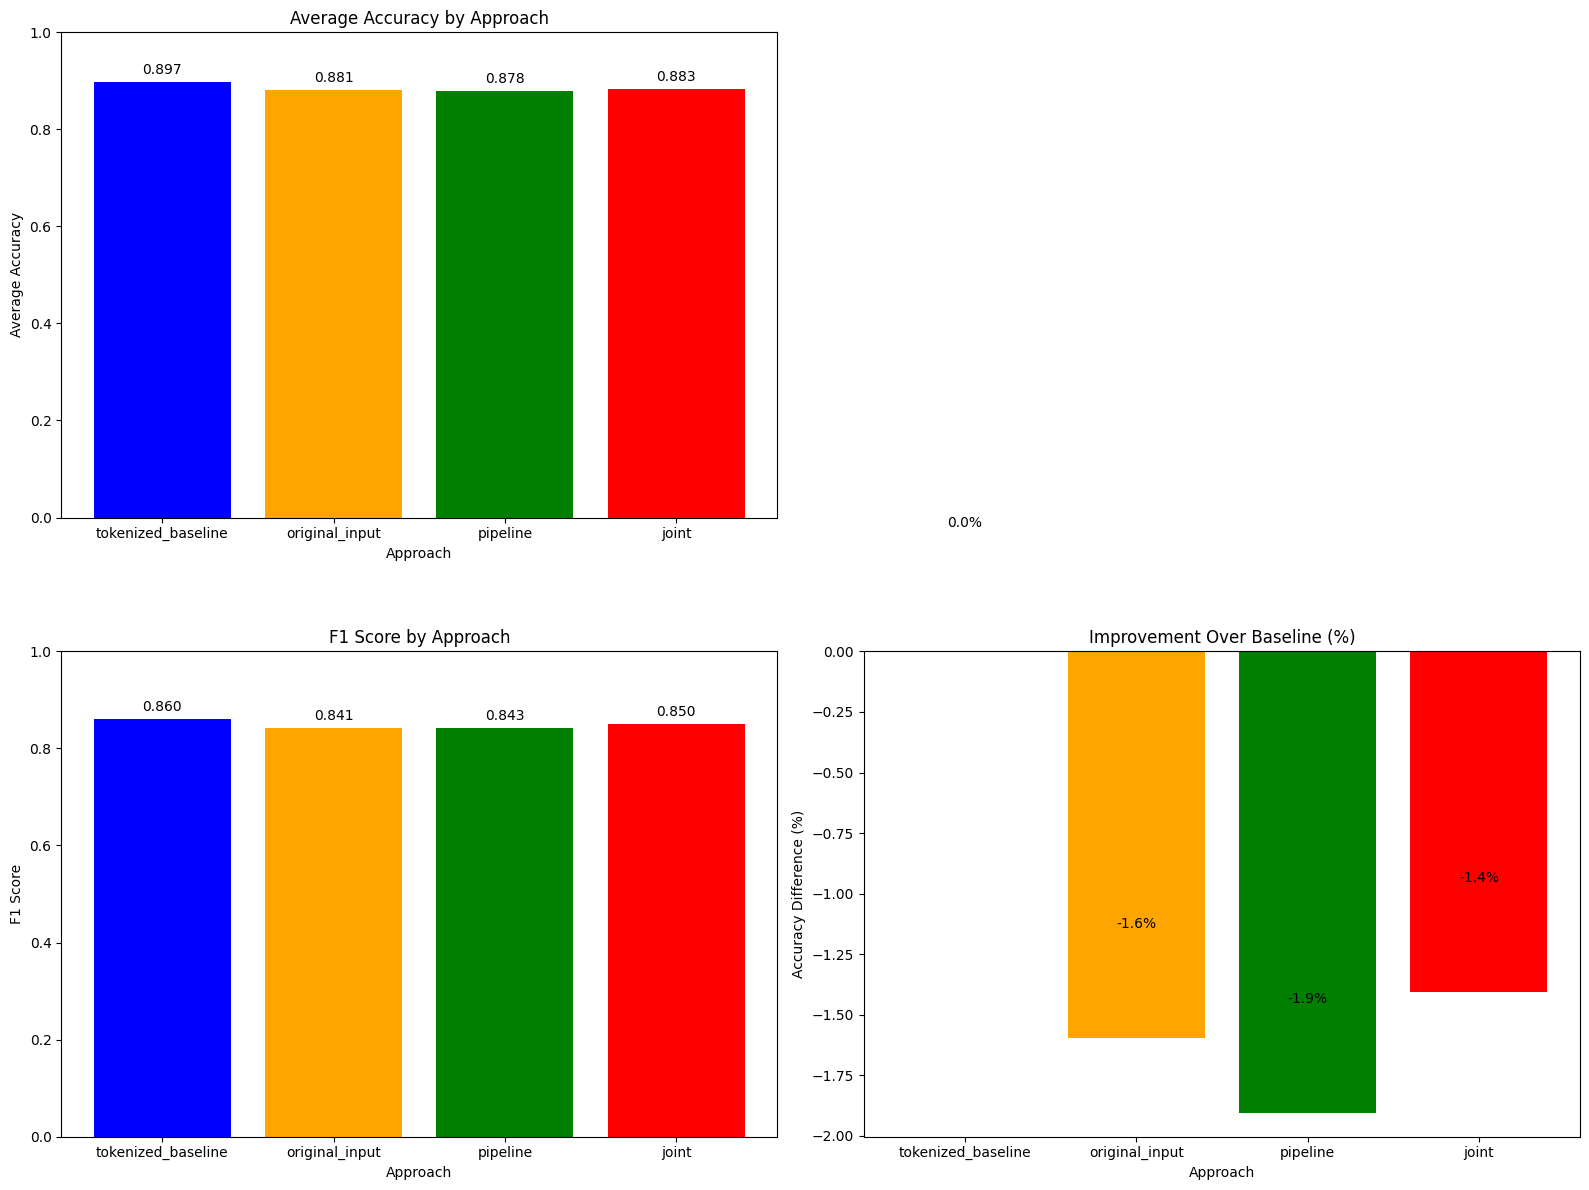

Best approach: tokenized_baseline
Number of sentences where segmentation improved results: 105

=== Alignment Statistics Summary ===

tokenized_baseline:
  Alignment rate: 0.074 (152/2065 cases)
  Average accuracy with alignment: 0.894
  Average token coverage: 0.833

original_input:
  Alignment rate: 0.376 (776/2062 cases)
  Average accuracy with alignment: 0.877
  Average token coverage: 0.831

pipeline:
  Alignment rate: 0.229 (467/2038 cases)
  Average accuracy with alignment: 0.858
  Average token coverage: 0.761

joint:
  Alignment rate: 0.231 (479/2071 cases)
  Average accuracy with alignment: 0.868
  Average token coverage: 0.787

=== Pipeline vs. Joint Approach Analysis ===
Pipeline better: 284 cases
Joint better: 402 cases
Equal performance: 1348 cases
Cases where alignment improved results: 201


In [125]:
# Analyze the results
analysis_results = analyze_tagging_approaches(comparison_results)

# Visualize the results
visualize_tagging_approach_results(analysis_results)


In [127]:
# Print detailed analysis
print("\nDetailed analysis of different approaches:")
for approach, summary in analysis_results['summaries'].items():
    print(f"\n=== {approach.upper()} ===")
    print(f"  Average accuracy: {summary['avg_accuracy']:.4f}")
    print(f"  Average F1 score: {summary['avg_f1']:.4f}")
    print(f"  Success rate: {summary['success_rate']:.4f} ({summary['successful_examples']}/{summary['total_examples']})")
    
    # Alignment statistics
    alignment_rate = summary['aligned_cases'] / summary['successful_examples'] if summary['successful_examples'] > 0 else 0
    print(f"  Alignment usage: {summary['aligned_cases']}/{summary['successful_examples']} cases ({alignment_rate:.2%})")
    
    if summary['aligned_cases'] > 0:
        print(f"  Average accuracy with alignment: {summary['avg_aligned_accuracy']:.4f}")
        print(f"  Average token coverage with alignment: {summary['avg_aligned_coverage']:.4f}")

# Print segmentation improvements if any
if analysis_results['segmentation_improvements']:
    print(f"\nFound {len(analysis_results['segmentation_improvements'])} sentences where segmentation improved results")
    
    # Show a few examples
    for improvement in analysis_results['segmentation_improvements'][:3]:
        print(f"\nSentence: {improvement['original_text'][:50]}...")
        print(f"Original accuracy: {improvement['original_accuracy']:.4f}")
        print(f"Pipeline accuracy: {improvement['pipeline_accuracy']:.4f}")
        print(f"Improvement: {improvement['pipeline_accuracy'] - improvement['original_accuracy']:.4f}")

# Pipeline vs. Joint comparison
if 'pipeline_vs_joint' in analysis_results and analysis_results['pipeline_vs_joint']:
    pipeline_better = sum(1 for comp in analysis_results['pipeline_vs_joint'] if comp['difference'] < 0)
    joint_better = sum(1 for comp in analysis_results['pipeline_vs_joint'] if comp['difference'] > 0)
    equal = sum(1 for comp in analysis_results['pipeline_vs_joint'] if comp['difference'] == 0)
    
    print("\n=== Pipeline vs. Joint Approach Analysis ===")
    print(f"Pipeline better: {pipeline_better} cases")
    print(f"Joint better: {joint_better} cases")
    print(f"Equal performance: {equal} cases")


Detailed analysis of different approaches:

=== TOKENIZED_BASELINE ===
  Average accuracy: 0.8974
  Average F1 score: 0.8600
  Success rate: 0.9942 (2065/2077)
  Alignment usage: 152/2065 cases (7.36%)
  Average accuracy with alignment: 0.8940
  Average token coverage with alignment: 0.8325

=== ORIGINAL_INPUT ===
  Average accuracy: 0.8815
  Average F1 score: 0.8415
  Success rate: 0.9928 (2062/2077)
  Alignment usage: 776/2062 cases (37.63%)
  Average accuracy with alignment: 0.8766
  Average token coverage with alignment: 0.8308

=== PIPELINE ===
  Average accuracy: 0.8784
  Average F1 score: 0.8428
  Success rate: 0.9812 (2038/2077)
  Alignment usage: 467/2038 cases (22.91%)
  Average accuracy with alignment: 0.8576
  Average token coverage with alignment: 0.7614

=== JOINT ===
  Average accuracy: 0.8834
  Average F1 score: 0.8499
  Success rate: 0.9971 (2071/2077)
  Alignment usage: 479/2071 cases (23.13%)
  Average accuracy with alignment: 0.8678
  Average token coverage with al

## Conclusion
All four approaches show lower accuracy compared to the tokenized baseline, though the differences are modest. 

Based on our detailed analysis, we can draw the following conclusions:

1. **Tokenization Quality Matters**: The "tokenized_baseline" approach (89.74% accuracy) significantly outperforms other methods, confirming that high-quality tokenization provides a strong foundation for POS tagging.

2. **Joint Approach Outperforms Pipeline**: The joint segmentation-and-tagging approach (88.34% accuracy) demonstrates better performance than the pipeline approach (87.84% accuracy), suggesting that considering both tasks simultaneously helps avoid error propagation.

3. **Error Propagation in Pipelines**: The pipeline approach underperforms because errors made during segmentation propagate to the tagging step, creating a compounding effect. This is evidenced by the higher alignment usage (22.91%) needed to compensate for segmentation errors.

4. **Token Alignment Requirements**: Different approaches required varying degrees of alignment:
   - Original input: 37.63% of cases
   - Joint approach: 23.13% of cases
   - Pipeline approach: 22.91% of cases
   - Tokenized baseline: 7.36% of cases
   
   These rates reflect the relative difficulty each approach has with maintaining token boundaries.

5. **Segmentation Impact**: We identified 105 sentences where proper segmentation significantly improved results, with improvements ranging from 16.86% to 28.57% in accuracy for challenging cases.

6. **Practical Trade-offs**: While the differences between approaches are relatively small (1.4-1.9% lower than baseline), they represent real-world scenarios where perfect tokenization isn't available. The joint approach offers the best balance of performance and practicality.

7. **Sentence-Level Analysis**: The joint approach outperformed the pipeline in 402 cases, while pipeline was better in 284 cases, with equal performance in 1348 cases, further supporting the advantage of joint processing.

The relatively modest accuracy differences suggest that modern language models are reasonably robust to tokenization variations, though specialized approaches still provide measurable benefits for POS tagging accuracy.

    
    
        
            
                







Done everything except for:

3.2.2
[OPTIONAL] It helps to select examples that are as similar as possible to the sentence to be segmented. The way to implement this "example selection" means that you prepare a list of "good examples" to illustrate how to deal with complex cases; given the sentence to be segmented, you select the top-3 most similar sentences based on a "similarity" function which identifies "relevant" examples. Implement this strategy and explain your assumptions about "relevance" in this context.